# Imports

This step involved cheaning data. Followed by combining databases containing treasury rate (r) and the option data. Calculating historial and calibrated volatility, tau (τ), and other parameters

In [ ]:
import tensorflow as tf
from tensorflow.keras import Input, layers, Model, utils, initializers, losses, optimizers, Sequential, callbacks, backend
import tensorflow.keras as K

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [ ]:
from scipy.stats import norm
import scipy.stats as measures

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
%matplotlib inline 
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.family'] = 'sans-serif'

In [ ]:
plt.rc('font', size=24)          # controls default text sizes
plt.rc('axes', titlesize=28)     # fontsize of the axes title
plt.rc('axes', labelsize=28)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=24)    # fontsize of the tick labels
plt.rc('ytick', labelsize=24)    # fontsize of the tick labels
plt.rc('legend', fontsize=24)    # legend fontsize
plt.rc('figure', titlesize=28)  # fontsize of the figure title

In [ ]:
from datetime import date

In [ ]:
import math

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


# Segragation based on moneyness2

In [ ]:
final_df = pd.read_csv('new_model_final_put_df.csv')

In [ ]:
call_df1 = final_df[final_df['moneyness2']<0.95]
call_df2 = final_df[final_df['moneyness2']<0.98]
call_df3 = final_df[final_df['moneyness2']<1.0]
call_df4 = final_df[final_df['moneyness2']<1.02]
call_df5 = final_df[final_df['moneyness2']<1.05]
call_df6 = final_df[1.05<=final_df['moneyness2']]

In [ ]:
call_df2 = call_df2[0.95<=call_df2['moneyness2']]
call_df3 = call_df3[0.98<=call_df3['moneyness2']]
call_df4 = call_df4[1.0<=call_df4['moneyness2']]
call_df5 = call_df5[1.02<=call_df5['moneyness2']]

In [ ]:
len(call_df1) + len(call_df2) + len(call_df3) + len(call_df4) + len(call_df5) + len(call_df6)  

317990

In [ ]:
call_df1.columns

Index(['K', 'stock_price', 'log_ret', 'sigma_20', 'cal_sig_20', 'delta_t', 'r',
       'tau', 'sharpe_ratio', 'moneyness1', 'moneyness2', 'log(K/S)',
       'log(K/S)0.5', 'log(K/S)0.95', 'arbitrage', 'S1', 'log_ret1', 'S2',
       'log_ret2', 'S3', 'log_ret3', 'S4', 'log_ret4', 'S5', 'log_ret5', 'S6',
       'log_ret6', 'S7', 'log_ret7', 'S8', 'log_ret8', 'S9', 'log_ret9', 'S10',
       'log_ret10', 'S11', 'log_ret11', 'S12', 'log_ret12', 'S13', 'log_ret13',
       'S14', 'log_ret14', 'S15', 'log_ret15', 'S16', 'log_ret16', 'S17',
       'log_ret17', 'S18', 'log_ret18', 'S19', 'log_ret19', 'S20', 'log_ret20',
       'impl_sig', 'option_price'],
      dtype='object')

# Model

In [ ]:
default_params = {
'LSTM_units': [16, 16, 16, 16],
'LR': 1e-5,
'Dense_units': [100, 100, 100],
'BN_MOMENTUM': 0.9,
'LEAKY_ALPHA': 0.1,
'BIAS_INIT': 'ones',
'KERNEL_INIT': 'glorot_normal',
}

In [ ]:
input_shape = (15)
close_history_shape = (20, 2)

In [ ]:
def build_model(hparams=default_params):
    
    y = Input(shape=input_shape, name='features')
    z = Input(shape=close_history_shape, name='close_history')
    
    x = layers.Bidirectional(layers.LSTM(units=hparams['LSTM_units'][0],
                                         bias_initializer=hparams['BIAS_INIT'],
                                         kernel_initializer=hparams['KERNEL_INIT'], 
                                         return_sequences=True))(z)

    for u in hparams['LSTM_units'][1:-1]:
        x = layers.Bidirectional(layers.LSTM(units=u,
                                             bias_initializer=hparams['BIAS_INIT'],
                                             kernel_initializer=hparams['KERNEL_INIT'], 
                                             return_sequences=True))(x)

    x = layers.Bidirectional(layers.LSTM(units=hparams['LSTM_units'][-1],
                                         bias_initializer=hparams['BIAS_INIT'],
                                         kernel_initializer=hparams['KERNEL_INIT'], 
                                         return_sequences=False))(x)
    x = layers.concatenate([x, y])

    x = layers.BatchNormalization(momentum=hparams['BN_MOMENTUM'])(x)

    for u in hparams['Dense_units']:
        x = layers.Dense(units=u, activation="linear")(x)
        x = layers.LeakyReLU(alpha=hparams['LEAKY_ALPHA'])(x)
        # x = layers.BatchNormalization(momentum=hparams['BN_MOMENTUM'])(x) 

    x = layers.Dense(units=1, activation="relu")(x)

    model = Model(inputs=[y, z], outputs=x, name="model_option_price") 

    model.compile(
        loss='mse',
        optimizer=optimizers.Adam(
            learning_rate=hparams['LR']
        )
    )
    print(model.summary())

    return model


In [ ]:
model = build_model()

Model: "model_option_price"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
close_history (InputLayer)      [(None, 20, 2)]      0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 20, 32)       2432        close_history[0][0]              
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 20, 32)       6272        bidirectional[0][0]              
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 20, 32)       6272        bidirectional_1[0][0]            
_________________________________________________________________________________

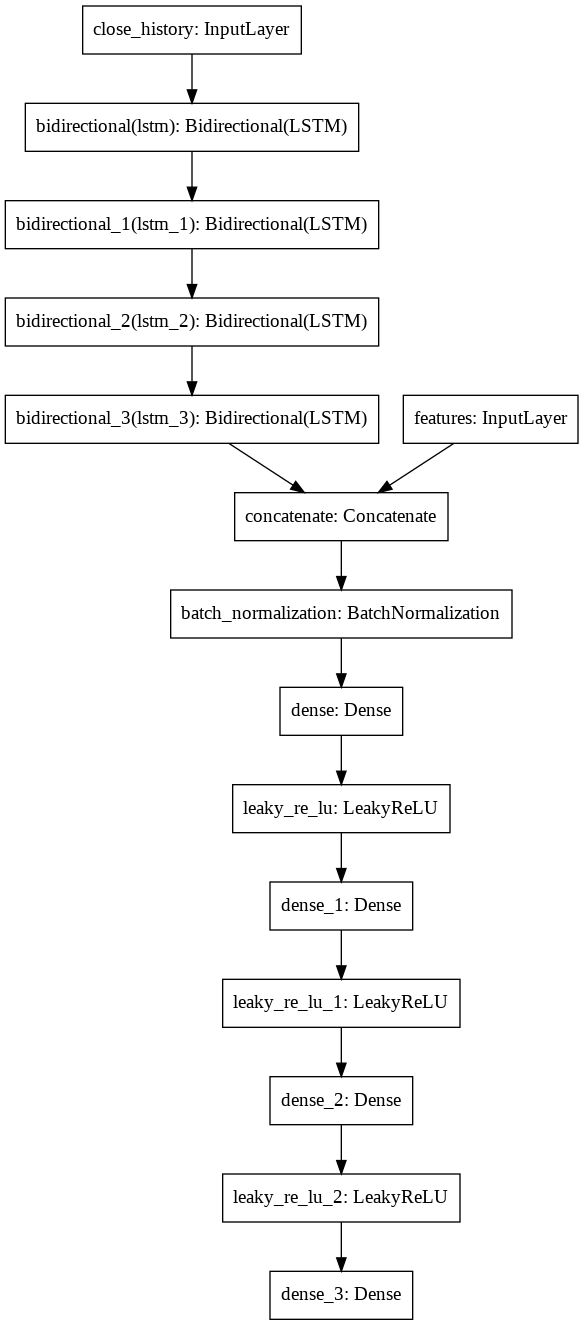

In [ ]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

## 1 - Deep-out-the-money

In [ ]:
lstm_call = call_df1

In [ ]:
lstm_call.head()

,K,stock_price,log_ret,sigma_20,cal_sig_20,delta_t,r,tau,sharpe_ratio,moneyness1,moneyness2,log(K/S),log(K/S)0.5,log(K/S)0.95,arbitrage,S1,log_ret1,S2,log_ret2,S3,log_ret3,S4,log_ret4,S5,log_ret5,S6,log_ret6,S7,log_ret7,S8,log_ret8,S9,log_ret9,S10,log_ret10,S11,log_ret11,S12,log_ret12,S13,log_ret13,S14,log_ret14,S15,log_ret15,S16,log_ret16,S17,log_ret17,S18,log_ret18,S19,log_ret19,S20,log_ret20,impl_sig,option_price
0,9100,8248.25,0.000236,0.008876,0.031192,0.076712,0.0835,0.082192,-9.613802,0.906401,0.912643,0.098273,0.342785,1.055234,801.30,8248.25,0.000236,8246.3,0.005545,8200.7,0.003249,8174.1,-0.011301,8267.0,-0.006871,8324.0,0.01194,8225.2,0.008044,8159.3,0.015999,8029.8,-0.004696,8067.6,-0.018666,8219.6,-0.000547,8224.1,-0.008331,8292.9,-0.007538,8355.65,0.001791,8340.7,-0.011628,8438.25,-0.011787,8538.3,-0.003052,8564.4,0.003128,8537.65,0.001518,8524.7,-0.003653,0.200466,801.30
1,8750,8248.25,0.000236,0.008876,0.031192,0.076712,0.0835,0.082192,-9.613802,0.942657,0.949149,0.059053,0.205980,0.634092,496.05,8248.25,0.000236,8246.3,0.005545,8200.7,0.003249,8174.1,-0.011301,8267.0,-0.006871,8324.0,0.01194,8225.2,0.008044,8159.3,0.015999,8029.8,-0.004696,8067.6,-0.018666,8219.6,-0.000547,8224.1,-0.008331,8292.9,-0.007538,8355.65,0.001791,8340.7,-0.011628,8438.25,-0.011787,8538.3,-0.003052,8564.4,0.003128,8537.65,0.001518,8524.7,-0.003653,0.209677,496.05
2,8850,8248.25,0.000236,0.008876,0.031192,0.076712,0.0835,0.082192,-9.613802,0.932006,0.938424,0.070416,0.245618,0.756113,574.70,8248.25,0.000236,8246.3,0.005545,8200.7,0.003249,8174.1,-0.011301,8267.0,-0.006871,8324.0,0.01194,8225.2,0.008044,8159.3,0.015999,8029.8,-0.004696,8067.6,-0.018666,8219.6,-0.000547,8224.1,-0.008331,8292.9,-0.007538,8355.65,0.001791,8340.7,-0.011628,8438.25,-0.011787,8538.3,-0.003052,8564.4,0.003128,8537.65,0.001518,8524.7,-0.003653,0.201022,574.70
3,8950,8248.25,0.000236,0.008876,0.031192,0.076712,0.0835,0.082192,-9.613802,0.921592,0.927939,0.081652,0.284810,0.876763,653.60,8248.25,0.000236,8246.3,0.005545,8200.7,0.003249,8174.1,-0.011301,8267.0,-0.006871,8324.0,0.01194,8225.2,0.008044,8159.3,0.015999,8029.8,-0.004696,8067.6,-0.018666,8219.6,-0.000547,8224.1,-0.008331,8292.9,-0.007538,8355.65,0.001791,8340.7,-0.011628,8438.25,-0.011787,8538.3,-0.003052,8564.4,0.003128,8537.65,0.001518,8524.7,-0.003653,0.175640,653.60
13,9000,8248.25,0.000236,0.008876,0.031192,0.076712,0.0835,0.158904,-9.613802,0.916472,0.928713,0.087224,0.218809,0.500674,655.75,8248.25,0.000236,8246.3,0.005545,8200.7,0.003249,8174.1,-0.011301,8267.0,-0.006871,8324.0,0.01194,8225.2,0.008044,8159.3,0.015999,8029.8,-0.004696,8067.6,-0.018666,8219.6,-0.000547,8224.1,-0.008331,8292.9,-0.007538,8355.65,0.001791,8340.7,-0.011628,8438.25,-0.011787,8538.3,-0.003052,8564.4,0.003128,8537.65,0.001518,8524.7,-0.003653,0.143504,655.75


In [ ]:
lstm_call.columns

Index(['K', 'stock_price', 'log_ret', 'sigma_20', 'cal_sig_20', 'delta_t', 'r',
       'tau', 'sharpe_ratio', 'moneyness1', 'moneyness2', 'log(K/S)',
       'log(K/S)0.5', 'log(K/S)0.95', 'arbitrage', 'S1', 'log_ret1', 'S2',
       'log_ret2', 'S3', 'log_ret3', 'S4', 'log_ret4', 'S5', 'log_ret5', 'S6',
       'log_ret6', 'S7', 'log_ret7', 'S8', 'log_ret8', 'S9', 'log_ret9', 'S10',
       'log_ret10', 'S11', 'log_ret11', 'S12', 'log_ret12', 'S13', 'log_ret13',
       'S14', 'log_ret14', 'S15', 'log_ret15', 'S16', 'log_ret16', 'S17',
       'log_ret17', 'S18', 'log_ret18', 'S19', 'log_ret19', 'S20', 'log_ret20',
       'impl_sig', 'option_price'],
      dtype='object')

In [ ]:
call_X_train, call_X_test, call_y_train, call_y_test = train_test_split(lstm_call.drop(['impl_sig'], axis=1).values,
                                                                        lstm_call.impl_sig.values,
                                                                        test_size=0.01, random_state=42)

In [ ]:
call_X_train_f1,call_X_train_f2,call_X_train_f3 = call_X_train[:,:15], call_X_train[:,15:55], call_X_train[:,55:]

In [ ]:
call_X_train_f2 = call_X_train_f2.reshape((call_X_train_f2.shape[0], 20, 2))

In [ ]:
call_X_test_f1,call_X_test_f2,call_X_test_f3 = call_X_test[:,:15], call_X_test[:,15:55], call_X_test[:,55:]

In [ ]:
call_X_test_f2.shape

(1242, 40)

In [ ]:
call_X_test_f2 = call_X_test_f2.reshape((call_X_test_f2.shape[0], 20, 2))

In [ ]:
def black_scholes_call(row):
  S = row['stock_price']
  K = row['K']
  T = row['tau']
  r = row['r']
  sig = row['impl_sig']
  d1 = (np.log(S / K) + (r + (sig ** 2) / 2) * T) / (sig * (T ** .5))
  d2 = d1 - sig * (T ** .5)
  C = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
  return C

def black_scholes_put(row):
  S = row['stock_price']
  K = row['K']
  T = row['tau']
  r = row['r']
  sig = row['impl_sig']
  d1 = (np.log(S / K) + (r + (sig ** 2) / 2) * T) / (sig * (T ** .5))
  d2 = d1 - sig * (T ** .5)
  P = - S * norm.cdf(-d1) + K * np.exp(-r * T) * norm.cdf(-d2)
  return P

In [ ]:
mape = tf.keras.losses.MeanAbsolutePercentageError()
mse = tf.keras.losses.MeanSquaredError()

In [ ]:
n_batch = 1024
total_epochs = 300
epoch_per_eval = 5
training_loss = []
val_loss = []
test_loss = []
test_epochs = []
max_errors = []
mapes = []
rmses = []
ccfs = []
predicted_option_prices = []
real_option_prices = []
for i in range(total_epochs// epoch_per_eval):
    history = model.fit([call_X_train_f1, call_X_train_f2], call_y_train, 
                        batch_size=n_batch, epochs=epoch_per_eval, 
                        validation_split = 0.01)
    training_loss += history.history['loss']
    val_loss += history.history['val_loss']
    print('#'*70)
    print('Results at epoch', (i + 1) * epoch_per_eval)
    history = model.evaluate([call_X_test_f1, call_X_test_f2],call_y_test, return_dict=True)
    test_epochs.append((i + 1) * epoch_per_eval)   
    test_loss.append(history['loss'])
    print(history)
    preds = model.predict([call_X_test_f1, call_X_test_f2])
    df = pd.DataFrame(data = call_X_test_f1, columns = ['K', 'stock_price', 
        'log_ret', 'sigma_20', 'cal_sig_20', 'delta_t', 'r',
       'tau', 'sharpe_ratio', 'moneyness1', 'moneyness2', 'log(K/S)',
       'log(K/S)0.5', 'log(K/S)0.95', 'arbitrage'])
    df['impl_sig'] = preds
    df['option_price'] = call_X_test_f3
    df['bsm_call'] = df.apply(lambda row: black_scholes_put(row),axis=1)
    df['error'] = abs(df['bsm_call']-df['option_price'])
    max_errors.append(df['error'].max())
    mapes.append(mape(df['option_price'].values, df['bsm_call'].values).numpy())
    rmses.append(math.sqrt(mse(df['option_price'].values, df['bsm_call'].values).numpy()))
    ccfs.append(measures.pearsonr(df['bsm_call'].values, df['option_price'].values)[0])
    if i == ((total_epochs// epoch_per_eval)-1):
      predicted_option_prices.append(df['bsm_call'].tolist())
      real_option_prices.append(df['option_price'].tolist())
    print(('max error: ', max_errors[-1]))
    print(('mape: ', mapes[-1]))
    print(('rmse: ', rmses[-1]))
    print(('ccf:', ccfs[-1]))
    print('#'*70)

Epoch 1/5
119/119 [==============================] - 44s 39ms/step - loss: 0.1562 - val_loss: 0.1076
Epoch 2/5
119/119 [==============================] - 2s 18ms/step - loss: 0.0905 - val_loss: 0.0764
Epoch 3/5
119/119 [==============================] - 2s 17ms/step - loss: 0.0684 - val_loss: 0.0649
Epoch 4/5
119/119 [==============================] - 2s 17ms/step - loss: 0.0579 - val_loss: 0.0572
Epoch 5/5
119/119 [==============================] - 2s 18ms/step - loss: 0.0506 - val_loss: 0.0509
######################################################################
Results at epoch 5
39/39 [==============================] - 0s 7ms/step - loss: 0.0468
{'loss': 0.046814970672130585}
('max error: ', 1349.4101295383284)
('mape: ', 14.641739845275879)
('rmse: ', 266.7316359658149)
('ccf:', 0.8816116462169091)
######################################################################
Epoch 1/5
  4/119 [>.............................] - ETA: 2s - loss: 0.0458

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars


119/119 [==============================] - 2s 18ms/step - loss: 0.0433 - val_loss: 0.0450
Epoch 2/5
119/119 [==============================] - 2s 18ms/step - loss: 0.0379 - val_loss: 0.0400
Epoch 3/5
119/119 [==============================] - 2s 18ms/step - loss: 0.0332 - val_loss: 0.0352
Epoch 4/5
119/119 [==============================] - 2s 18ms/step - loss: 0.0289 - val_loss: 0.0313
Epoch 5/5
119/119 [==============================] - 2s 18ms/step - loss: 0.0255 - val_loss: 0.0279
######################################################################
Results at epoch 10
39/39 [==============================] - 0s 7ms/step - loss: 0.0242
{'loss': 0.024240372702479362}
('max error: ', 1219.5810809438444)
('mape: ', 9.069011688232422)
('rmse: ', 168.46778484698493)
('ccf:', 0.9555270886892372)
######################################################################
Epoch 1/5
119/119 [==============================] - 2s 18ms/step - loss: 0.0224 - val_loss: 0.0247
Epoch 2/5
119/119 [====

## 2 - Out-the-money

In [ ]:
lstm_call = call_df2

In [ ]:
lstm_call.head()

,K,stock_price,log_ret,sigma_20,cal_sig_20,delta_t,r,tau,sharpe_ratio,moneyness1,moneyness2,log(K/S),log(K/S)0.5,log(K/S)0.95,arbitrage,S1,log_ret1,S2,log_ret2,S3,log_ret3,S4,log_ret4,S5,log_ret5,S6,log_ret6,S7,log_ret7,S8,log_ret8,S9,log_ret9,S10,log_ret10,S11,log_ret11,S12,log_ret12,S13,log_ret13,S14,log_ret14,S15,log_ret15,S16,log_ret16,S17,log_ret17,S18,log_ret18,S19,log_ret19,S20,log_ret20,impl_sig,option_price
5,8500,8248.25,0.000236,0.008876,0.031192,0.076712,0.0835,0.082192,-9.613802,0.970382,0.977065,0.030065,0.104869,0.322831,227.40,8248.25,0.000236,8246.3,0.005545,8200.7,0.003249,8174.1,-0.011301,8267.0,-0.006871,8324.0,0.01194,8225.2,0.008044,8159.3,0.015999,8029.8,-0.004696,8067.6,-0.018666,8219.6,-0.000547,8224.1,-0.008331,8292.9,-0.007538,8355.65,0.001791,8340.7,-0.011628,8438.25,-0.011787,8538.3,-0.003052,8564.4,0.003128,8537.65,0.001518,8524.7,-0.003653,0.107808,227.40
6,8550,8248.25,0.000236,0.008876,0.031192,0.076712,0.0835,0.082192,-9.613802,0.964708,0.971351,0.035930,0.125327,0.385810,282.85,8248.25,0.000236,8246.3,0.005545,8200.7,0.003249,8174.1,-0.011301,8267.0,-0.006871,8324.0,0.01194,8225.2,0.008044,8159.3,0.015999,8029.8,-0.004696,8067.6,-0.018666,8219.6,-0.000547,8224.1,-0.008331,8292.9,-0.007538,8355.65,0.001791,8340.7,-0.011628,8438.25,-0.011787,8538.3,-0.003052,8564.4,0.003128,8537.65,0.001518,8524.7,-0.003653,0.131048,282.85
7,8600,8248.25,0.000236,0.008876,0.031192,0.076712,0.0835,0.082192,-9.613802,0.959099,0.965704,0.041761,0.145666,0.448420,307.70,8248.25,0.000236,8246.3,0.005545,8200.7,0.003249,8174.1,-0.011301,8267.0,-0.006871,8324.0,0.01194,8225.2,0.008044,8159.3,0.015999,8029.8,-0.004696,8067.6,-0.018666,8219.6,-0.000547,8224.1,-0.008331,8292.9,-0.007538,8355.65,0.001791,8340.7,-0.011628,8438.25,-0.011787,8538.3,-0.003052,8564.4,0.003128,8537.65,0.001518,8524.7,-0.003653,0.103707,307.70
8,8650,8248.25,0.000236,0.008876,0.031192,0.076712,0.0835,0.082192,-9.613802,0.953555,0.960122,0.047558,0.165887,0.510668,350.00,8248.25,0.000236,8246.3,0.005545,8200.7,0.003249,8174.1,-0.011301,8267.0,-0.006871,8324.0,0.01194,8225.2,0.008044,8159.3,0.015999,8029.8,-0.004696,8067.6,-0.018666,8219.6,-0.000547,8224.1,-0.008331,8292.9,-0.007538,8355.65,0.001791,8340.7,-0.011628,8438.25,-0.011787,8538.3,-0.003052,8564.4,0.003128,8537.65,0.001518,8524.7,-0.003653,0.096874,350.00
14,8700,8248.25,0.000236,0.008876,0.031192,0.076712,0.0835,0.158904,-9.613802,0.948075,0.960738,0.053322,0.133764,0.306075,369.90,8248.25,0.000236,8246.3,0.005545,8200.7,0.003249,8174.1,-0.011301,8267.0,-0.006871,8324.0,0.01194,8225.2,0.008044,8159.3,0.015999,8029.8,-0.004696,8067.6,-0.018666,8219.6,-0.000547,8224.1,-0.008331,8292.9,-0.007538,8355.65,0.001791,8340.7,-0.011628,8438.25,-0.011787,8538.3,-0.003052,8564.4,0.003128,8537.65,0.001518,8524.7,-0.003653,0.106170,369.90


In [ ]:
lstm_call.columns

Index(['K', 'stock_price', 'log_ret', 'sigma_20', 'cal_sig_20', 'delta_t', 'r',
       'tau', 'sharpe_ratio', 'moneyness1', 'moneyness2', 'log(K/S)',
       'log(K/S)0.5', 'log(K/S)0.95', 'arbitrage', 'S1', 'log_ret1', 'S2',
       'log_ret2', 'S3', 'log_ret3', 'S4', 'log_ret4', 'S5', 'log_ret5', 'S6',
       'log_ret6', 'S7', 'log_ret7', 'S8', 'log_ret8', 'S9', 'log_ret9', 'S10',
       'log_ret10', 'S11', 'log_ret11', 'S12', 'log_ret12', 'S13', 'log_ret13',
       'S14', 'log_ret14', 'S15', 'log_ret15', 'S16', 'log_ret16', 'S17',
       'log_ret17', 'S18', 'log_ret18', 'S19', 'log_ret19', 'S20', 'log_ret20',
       'impl_sig', 'option_price'],
      dtype='object')

In [ ]:
call_X_train, call_X_test, call_y_train, call_y_test = train_test_split(lstm_call.drop(['impl_sig'], axis=1).values,
                                                                        lstm_call.impl_sig.values,
                                                                        test_size=0.01, random_state=42)

In [ ]:
call_X_train_f1,call_X_train_f2,call_X_train_f3 = call_X_train[:,:15], call_X_train[:,15:55], call_X_train[:,55:]

In [ ]:
call_X_train_f2.shape

(57079, 40)

In [ ]:
call_X_train_f2 = call_X_train_f2.reshape((call_X_train_f2.shape[0], 20, 2))

In [ ]:
call_X_test_f1,call_X_test_f2,call_X_test_f3 = call_X_test[:,:15], call_X_test[:,15:55], call_X_test[:,55:]

In [ ]:
call_X_test_f2.shape

(577, 40)

In [ ]:
call_X_test_f2 = call_X_test_f2.reshape((call_X_test_f2.shape[0], 20, 2))

In [ ]:
def black_scholes_call(row):
  S = row['stock_price']
  K = row['K']
  T = row['tau']
  r = row['r']
  sig = row['impl_sig']
  d1 = (np.log(S / K) + (r + (sig ** 2) / 2) * T) / (sig * (T ** .5))
  d2 = d1 - sig * (T ** .5)
  C = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
  return C

def black_scholes_put(row):
  S = row['stock_price']
  K = row['K']
  T = row['tau']
  r = row['r']
  sig = row['impl_sig']
  d1 = (np.log(S / K) + (r + (sig ** 2) / 2) * T) / (sig * (T ** .5))
  d2 = d1 - sig * (T ** .5)
  C = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
  return C

In [ ]:
mape = tf.keras.losses.MeanAbsolutePercentageError()
mse = tf.keras.losses.MeanSquaredError()

In [ ]:
n_batch = 1024
total_epochs = 300
epoch_per_eval = 5
# training_loss = []
# val_loss = []
# test_loss = []
# test_epochs = []
# max_errors = []
# mapes = []
# rmses = []
# ccfs = []
for i in range(total_epochs// epoch_per_eval):
    history = model.fit([call_X_train_f1, call_X_train_f2], call_y_train, 
                        batch_size=n_batch, epochs=epoch_per_eval, 
                        validation_split = 0.01)
    training_loss += history.history['loss']
    val_loss += history.history['val_loss']
    print('#'*70)
    print('Results at epoch', (i + 1) * epoch_per_eval)
    history = model.evaluate([call_X_test_f1, call_X_test_f2],call_y_test, return_dict=True)
    test_epochs.append((i + 1) * epoch_per_eval)   
    test_loss.append(history['loss'])
    print(history)
    preds = model.predict([call_X_test_f1, call_X_test_f2])
    df = pd.DataFrame(data = call_X_test_f1, columns = ['K', 'stock_price', 
        'log_ret', 'sigma_20', 'cal_sig_20', 'delta_t', 'r',
       'tau', 'sharpe_ratio', 'moneyness1', 'moneyness2', 'log(K/S)',
       'log(K/S)0.5', 'log(K/S)0.95', 'arbitrage'])
    df['impl_sig'] = preds
    df['option_price'] = call_X_test_f3
    df['bsm_call'] = df.apply(lambda row: black_scholes_put(row),axis=1)
    df['error'] = abs(df['bsm_call']-df['option_price'])
    max_errors.append(df['error'].max())
    mapes.append(mape(df['option_price'].values, df['bsm_call'].values).numpy())
    rmses.append(math.sqrt(mse(df['option_price'].values, df['bsm_call'].values).numpy()))
    ccfs.append(measures.pearsonr(df['bsm_call'].values, df['option_price'].values)[0])
    if i == ((total_epochs// epoch_per_eval)-1):
      predicted_option_prices.append(df['bsm_call'].tolist())
      real_option_prices.append(df['option_price'].tolist())
    print(('max error: ', max_errors[-1]))
    print(('mape: ', mapes[-1]))
    print(('rmse: ', rmses[-1]))
    print(('ccf:', ccfs[-1]))
    print('#'*70)

Epoch 1/5
56/56 [==============================] - 1s 19ms/step - loss: 0.0168 - val_loss: 0.0089
Epoch 2/5
56/56 [==============================] - 1s 18ms/step - loss: 0.0082 - val_loss: 0.0055
Epoch 3/5
56/56 [==============================] - 1s 19ms/step - loss: 0.0060 - val_loss: 0.0042
Epoch 4/5
56/56 [==============================] - 1s 18ms/step - loss: 0.0047 - val_loss: 0.0030
Epoch 5/5
56/56 [==============================] - 1s 18ms/step - loss: 0.0038 - val_loss: 0.0024
######################################################################
Results at epoch 5
19/19 [==============================] - 0s 7ms/step - loss: 0.0028
{'loss': 0.002788158133625984}
('max error: ', 811.9577533593839)
('mape: ', 51.58381652832031)
('rmse: ', 379.9363433524095)
('ccf:', 0.9296309028145862)
######################################################################
Epoch 1/5
 1/56 [..............................] - ETA: 0s - loss: 0.0038

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars


56/56 [==============================] - 1s 19ms/step - loss: 0.0032 - val_loss: 0.0021
Epoch 2/5
56/56 [==============================] - 1s 18ms/step - loss: 0.0028 - val_loss: 0.0019
Epoch 3/5
56/56 [==============================] - 1s 18ms/step - loss: 0.0025 - val_loss: 0.0017
Epoch 4/5
56/56 [==============================] - 1s 18ms/step - loss: 0.0023 - val_loss: 0.0017
Epoch 5/5
56/56 [==============================] - 1s 18ms/step - loss: 0.0021 - val_loss: 0.0015
######################################################################
Results at epoch 10
19/19 [==============================] - 0s 7ms/step - loss: 0.0013
{'loss': 0.0013178850058466196}
('max error: ', 846.2901591308819)
('mape: ', 51.7916374206543)
('rmse: ', 382.01544062380515)
('ccf:', 0.9369060092733467)
######################################################################
Epoch 1/5
56/56 [==============================] - 1s 19ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 2/5
56/56 [===================

## 3 - Near-out-the-Money

In [ ]:
lstm_call = call_df3

In [ ]:
lstm_call.head()

,K,stock_price,log_ret,sigma_20,cal_sig_20,delta_t,r,tau,sharpe_ratio,moneyness1,moneyness2,log(K/S),log(K/S)0.5,log(K/S)0.95,arbitrage,S1,log_ret1,S2,log_ret2,S3,log_ret3,S4,log_ret4,S5,log_ret5,S6,log_ret6,S7,log_ret7,S8,log_ret8,S9,log_ret9,S10,log_ret10,S11,log_ret11,S12,log_ret12,S13,log_ret13,S14,log_ret14,S15,log_ret15,S16,log_ret16,S17,log_ret17,S18,log_ret18,S19,log_ret19,S20,log_ret20,impl_sig,option_price
4,8450,8248.25,0.000236,0.008876,0.031192,0.076712,0.0835,0.082192,-9.613802,0.976124,0.982846,0.024165,0.084291,0.259482,209.00,8248.25,0.000236,8246.3,0.005545,8200.7,0.003249,8174.1,-0.011301,8267.0,-0.006871,8324.0,0.01194,8225.2,0.008044,8159.3,0.015999,8029.8,-0.004696,8067.6,-0.018666,8219.6,-0.000547,8224.1,-0.008331,8292.9,-0.007538,8355.65,0.001791,8340.7,-0.011628,8438.25,-0.011787,8538.3,-0.003052,8564.4,0.003128,8537.65,0.001518,8524.7,-0.003653,0.130264,209.00
11,8350,8248.25,0.000236,0.008876,0.031192,0.076712,0.0835,0.082192,-9.613802,0.987814,0.994617,0.012260,0.042765,0.131650,142.30,8248.25,0.000236,8246.3,0.005545,8200.7,0.003249,8174.1,-0.011301,8267.0,-0.006871,8324.0,0.01194,8225.2,0.008044,8159.3,0.015999,8029.8,-0.004696,8067.6,-0.018666,8219.6,-0.000547,8224.1,-0.008331,8292.9,-0.007538,8355.65,0.001791,8340.7,-0.011628,8438.25,-0.011787,8538.3,-0.003052,8564.4,0.003128,8537.65,0.001518,8524.7,-0.003653,0.125435,142.30
12,8400,8248.25,0.000236,0.008876,0.031192,0.076712,0.0835,0.082192,-9.613802,0.981935,0.988697,0.018231,0.063590,0.195756,168.40,8248.25,0.000236,8246.3,0.005545,8200.7,0.003249,8174.1,-0.011301,8267.0,-0.006871,8324.0,0.01194,8225.2,0.008044,8159.3,0.015999,8029.8,-0.004696,8067.6,-0.018666,8219.6,-0.000547,8224.1,-0.008331,8292.9,-0.007538,8355.65,0.001791,8340.7,-0.011628,8438.25,-0.011787,8538.3,-0.003052,8564.4,0.003128,8537.65,0.001518,8524.7,-0.003653,0.121386,168.40
16,8400,8248.25,0.000236,0.008876,0.031192,0.076712,0.0835,0.158904,-9.613802,0.981935,0.995050,0.018231,0.045734,0.104646,203.05,8248.25,0.000236,8246.3,0.005545,8200.7,0.003249,8174.1,-0.011301,8267.0,-0.006871,8324.0,0.01194,8225.2,0.008044,8159.3,0.015999,8029.8,-0.004696,8067.6,-0.018666,8219.6,-0.000547,8224.1,-0.008331,8292.9,-0.007538,8355.65,0.001791,8340.7,-0.011628,8438.25,-0.011787,8538.3,-0.003052,8564.4,0.003128,8537.65,0.001518,8524.7,-0.003653,0.138270,203.05
17,8450,8248.25,0.000236,0.008876,0.031192,0.076712,0.0835,0.158904,-9.613802,0.976124,0.989162,0.024165,0.060621,0.138712,112.70,8248.25,0.000236,8246.3,0.005545,8200.7,0.003249,8174.1,-0.011301,8267.0,-0.006871,8324.0,0.01194,8225.2,0.008044,8159.3,0.015999,8029.8,-0.004696,8067.6,-0.018666,8219.6,-0.000547,8224.1,-0.008331,8292.9,-0.007538,8355.65,0.001791,8340.7,-0.011628,8438.25,-0.011787,8538.3,-0.003052,8564.4,0.003128,8537.65,0.001518,8524.7,-0.003653,0.042734,112.70


In [ ]:
lstm_call.columns

Index(['K', 'stock_price', 'log_ret', 'sigma_20', 'cal_sig_20', 'delta_t', 'r',
       'tau', 'sharpe_ratio', 'moneyness1', 'moneyness2', 'log(K/S)',
       'log(K/S)0.5', 'log(K/S)0.95', 'arbitrage', 'S1', 'log_ret1', 'S2',
       'log_ret2', 'S3', 'log_ret3', 'S4', 'log_ret4', 'S5', 'log_ret5', 'S6',
       'log_ret6', 'S7', 'log_ret7', 'S8', 'log_ret8', 'S9', 'log_ret9', 'S10',
       'log_ret10', 'S11', 'log_ret11', 'S12', 'log_ret12', 'S13', 'log_ret13',
       'S14', 'log_ret14', 'S15', 'log_ret15', 'S16', 'log_ret16', 'S17',
       'log_ret17', 'S18', 'log_ret18', 'S19', 'log_ret19', 'S20', 'log_ret20',
       'impl_sig', 'option_price'],
      dtype='object')

In [ ]:
call_X_train, call_X_test, call_y_train, call_y_test = train_test_split(lstm_call.drop(['impl_sig'], axis=1).values,
                                                                        lstm_call.impl_sig.values,
                                                                        test_size=0.01, random_state=42)

In [ ]:
call_X_train_f1,call_X_train_f2,call_X_train_f3 = call_X_train[:,:15], call_X_train[:,15:55], call_X_train[:,55:]

In [ ]:
call_X_train_f2.shape

(41310, 40)

In [ ]:
call_X_train_f2 = call_X_train_f2.reshape((call_X_train_f2.shape[0], 20, 2))

In [ ]:
call_X_test_f1,call_X_test_f2,call_X_test_f3 = call_X_test[:,:15], call_X_test[:,15:55], call_X_test[:,55:]

In [ ]:
call_X_test_f2.shape

(418, 40)

In [ ]:
call_X_test_f2 = call_X_test_f2.reshape((call_X_test_f2.shape[0], 20, 2))

In [ ]:
def black_scholes_call(row):
  S = row['stock_price']
  K = row['K']
  T = row['tau']
  r = row['r']
  sig = row['impl_sig']
  d1 = (np.log(S / K) + (r + (sig ** 2) / 2) * T) / (sig * (T ** .5))
  d2 = d1 - sig * (T ** .5)
  C = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
  return C

def black_scholes_put(row):
  S = row['stock_price']
  K = row['K']
  T = row['tau']
  r = row['r']
  sig = row['impl_sig']
  d1 = (np.log(S / K) + (r + (sig ** 2) / 2) * T) / (sig * (T ** .5))
  d2 = d1 - sig * (T ** .5)
  P = - S * norm.cdf(-d1) + K * np.exp(-r * T) * norm.cdf(-d2)
  return P

In [ ]:
mape = tf.keras.losses.MeanAbsolutePercentageError()
mse = tf.keras.losses.MeanSquaredError()

In [ ]:
n_batch = 1024
total_epochs = 350
epoch_per_eval = 5
# training_loss3 = []
# val_loss3 = []
# test_loss3 = []
# test_epochs = []
# max_errors3 = []
# mapes3 = []
# rmses3 = []
# ccfs3 = []
for i in range(total_epochs// epoch_per_eval):
    history = model.fit([call_X_train_f1, call_X_train_f2], call_y_train, 
                        batch_size=n_batch, epochs=epoch_per_eval, 
                        validation_split = 0.01)
    training_loss += history.history['loss']
    val_loss += history.history['val_loss']
    print('#'*70)
    print('Results at epoch', (i + 1) * epoch_per_eval)
    history = model.evaluate([call_X_test_f1, call_X_test_f2],call_y_test, return_dict=True)
    test_epochs.append((i + 1) * epoch_per_eval)   
    test_loss.append(history['loss'])
    print(history)
    preds = model.predict([call_X_test_f1, call_X_test_f2])
    df = pd.DataFrame(data = call_X_test_f1, columns = ['K', 'stock_price', 
        'log_ret', 'sigma_20', 'cal_sig_20', 'delta_t', 'r',
       'tau', 'sharpe_ratio', 'moneyness1', 'moneyness2', 'log(K/S)',
       'log(K/S)0.5', 'log(K/S)0.95', 'arbitrage'])
    df['impl_sig'] = preds
    df['option_price'] = call_X_test_f3
    df['bsm_call'] = df.apply(lambda row: black_scholes_put(row),axis=1)
    df['error'] = abs(df['bsm_call']-df['option_price'])
    max_errors.append(df['error'].max())
    mapes.append(mape(df['option_price'].values, df['bsm_call'].values).numpy())
    rmses.append(math.sqrt(mse(df['option_price'].values, df['bsm_call'].values).numpy()))
    ccfs.append(measures.pearsonr(df['bsm_call'].values, df['option_price'].values)[0])
    if i == ((total_epochs// epoch_per_eval)-1):
      predicted_option_prices.append(df['bsm_call'].tolist())
      real_option_prices.append(df['option_price'].tolist())
    print(('max error: ', max_errors[-1]))
    print(('mape: ', mapes[-1]))
    print(('rmse: ', rmses[-1]))
    print(('ccf:', ccfs[-1]))
    print('#'*70)

Epoch 1/5
40/40 [==============================] - 1s 20ms/step - loss: 0.0043 - val_loss: 0.0035
Epoch 2/5
40/40 [==============================] - 1s 19ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 3/5
40/40 [==============================] - 1s 19ms/step - loss: 0.0025 - val_loss: 0.0026
Epoch 4/5
40/40 [==============================] - 1s 19ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 5/5
40/40 [==============================] - 1s 19ms/step - loss: 0.0021 - val_loss: 0.0021
######################################################################
Results at epoch 5
14/14 [==============================] - 0s 7ms/step - loss: 0.0021
{'loss': 0.002144117606803775}
('max error: ', 569.6807365199779)
('mape: ', 9.905587196350098)
('rmse: ', 89.0305699342226)
('ccf:', 0.9791641145120622)
######################################################################
Epoch 1/5
 4/40 [==>...........................] - ETA: 0s - loss: 0.0018

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars


40/40 [==============================] - 1s 19ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 2/5
40/40 [==============================] - 1s 18ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 3/5
40/40 [==============================] - 1s 18ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 4/5
40/40 [==============================] - 1s 18ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 5/5
40/40 [==============================] - 1s 18ms/step - loss: 0.0016 - val_loss: 0.0016
######################################################################
Results at epoch 10
14/14 [==============================] - 0s 7ms/step - loss: 0.0016
{'loss': 0.0015980853931978345}
('max error: ', 501.41433588523387)
('mape: ', 8.61320972442627)
('rmse: ', 78.48273720419351)
('ccf:', 0.9840227343498767)
######################################################################
Epoch 1/5
40/40 [==============================] - 1s 19ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 2/5
40/40 [===================

## 4 - Near-in-the-money

In [ ]:
lstm_call = call_df4

In [ ]:
lstm_call.head()

,K,stock_price,log_ret,sigma_20,cal_sig_20,delta_t,r,tau,sharpe_ratio,moneyness1,moneyness2,log(K/S),log(K/S)0.5,log(K/S)0.95,arbitrage,S1,log_ret1,S2,log_ret2,S3,log_ret3,S4,log_ret4,S5,log_ret5,S6,log_ret6,S7,log_ret7,S8,log_ret8,S9,log_ret9,S10,log_ret10,S11,log_ret11,S12,log_ret12,S13,log_ret13,S14,log_ret14,S15,log_ret15,S16,log_ret16,S17,log_ret17,S18,log_ret18,S19,log_ret19,S20,log_ret20,impl_sig,option_price
9,8250,8248.25,0.000236,0.008876,0.031192,0.076712,0.0835,0.082192,-9.613802,0.999788,1.006673,0.000212,0.000740,0.002278,48.023985,8248.25,0.000236,8246.3,0.005545,8200.7,0.003249,8174.1,-0.011301,8267.0,-0.006871,8324.0,0.01194,8225.2,0.008044,8159.3,0.015999,8029.8,-0.004696,8067.6,-0.018666,8219.6,-0.000547,8224.1,-0.008331,8292.9,-0.007538,8355.65,0.001791,8340.7,-0.011628,8438.25,-0.011787,8538.3,-0.003052,8564.4,0.003128,8537.65,0.001518,8524.7,-0.003653,0.136341,102.70
10,8300,8248.25,0.000236,0.008876,0.031192,0.076712,0.0835,0.082192,-9.613802,0.993765,1.000609,0.006254,0.021816,0.067159,116.532009,8248.25,0.000236,8246.3,0.005545,8200.7,0.003249,8174.1,-0.011301,8267.0,-0.006871,8324.0,0.01194,8225.2,0.008044,8159.3,0.015999,8029.8,-0.004696,8067.6,-0.018666,8219.6,-0.000547,8224.1,-0.008331,8292.9,-0.007538,8355.65,0.001791,8340.7,-0.011628,8438.25,-0.011787,8538.3,-0.003052,8564.4,0.003128,8537.65,0.001518,8524.7,-0.003653,0.131536,121.55
15,8350,8248.25,0.000236,0.008876,0.031192,0.076712,0.0835,0.158904,-9.613802,0.987814,1.001009,0.012260,0.030757,0.070377,74.189863,8248.25,0.000236,8246.3,0.005545,8200.7,0.003249,8174.1,-0.011301,8267.0,-0.006871,8324.0,0.01194,8225.2,0.008044,8159.3,0.015999,8029.8,-0.004696,8067.6,-0.018666,8219.6,-0.000547,8224.1,-0.008331,8292.9,-0.007538,8355.65,0.001791,8340.7,-0.011628,8438.25,-0.011787,8538.3,-0.003052,8564.4,0.003128,8537.65,0.001518,8524.7,-0.003653,0.066049,82.50
20,8300,8248.25,0.000236,0.008876,0.031192,0.076712,0.0835,0.158904,-9.613802,0.993765,1.007039,0.006254,0.015690,0.035901,95.748906,8248.25,0.000236,8246.3,0.005545,8200.7,0.003249,8174.1,-0.011301,8267.0,-0.006871,8324.0,0.01194,8225.2,0.008044,8159.3,0.015999,8029.8,-0.004696,8067.6,-0.018666,8219.6,-0.000547,8224.1,-0.008331,8292.9,-0.007538,8355.65,0.001791,8340.7,-0.011628,8438.25,-0.011787,8538.3,-0.003052,8564.4,0.003128,8537.65,0.001518,8524.7,-0.003653,0.138309,153.40
52,8250,8248.25,0.000236,0.008876,0.031192,0.076712,0.0835,0.235616,-9.613802,0.999788,1.019652,0.000212,0.000437,0.000838,66.425950,8248.25,0.000236,8246.3,0.005545,8200.7,0.003249,8174.1,-0.011301,8267.0,-0.006871,8324.0,0.01194,8225.2,0.008044,8159.3,0.015999,8029.8,-0.004696,8067.6,-0.018666,8219.6,-0.000547,8224.1,-0.008331,8292.9,-0.007538,8355.65,0.001791,8340.7,-0.011628,8438.25,-0.011787,8538.3,-0.003052,8564.4,0.003128,8537.65,0.001518,8524.7,-0.003653,0.188563,225.40


In [ ]:
lstm_call.columns

Index(['K', 'stock_price', 'log_ret', 'sigma_20', 'cal_sig_20', 'delta_t', 'r',
       'tau', 'sharpe_ratio', 'moneyness1', 'moneyness2', 'log(K/S)',
       'log(K/S)0.5', 'log(K/S)0.95', 'arbitrage', 'S1', 'log_ret1', 'S2',
       'log_ret2', 'S3', 'log_ret3', 'S4', 'log_ret4', 'S5', 'log_ret5', 'S6',
       'log_ret6', 'S7', 'log_ret7', 'S8', 'log_ret8', 'S9', 'log_ret9', 'S10',
       'log_ret10', 'S11', 'log_ret11', 'S12', 'log_ret12', 'S13', 'log_ret13',
       'S14', 'log_ret14', 'S15', 'log_ret15', 'S16', 'log_ret16', 'S17',
       'log_ret17', 'S18', 'log_ret18', 'S19', 'log_ret19', 'S20', 'log_ret20',
       'impl_sig', 'option_price'],
      dtype='object')

In [ ]:
call_X_train, call_X_test, call_y_train, call_y_test = train_test_split(lstm_call.drop(['impl_sig'], axis=1).values,
                                                                        lstm_call.impl_sig.values,
                                                                        test_size=0.01, random_state=42)

In [ ]:
call_X_train_f1,call_X_train_f2,call_X_train_f3 = call_X_train[:,:15], call_X_train[:,15:55], call_X_train[:,55:]

In [ ]:
call_X_train_f2 = call_X_train_f2.reshape((call_X_train_f2.shape[0], 20, 2))

In [ ]:
call_X_test_f1,call_X_test_f2,call_X_test_f3 = call_X_test[:,:15], call_X_test[:,15:55], call_X_test[:,55:]

In [ ]:
call_X_test_f2.shape

(366, 40)

In [ ]:
call_X_test_f2 = call_X_test_f2.reshape((call_X_test_f2.shape[0], 20, 2))

In [ ]:
def black_scholes_call(row):
  S = row['stock_price']
  K = row['K']
  T = row['tau']
  r = row['r']
  sig = row['impl_sig']
  d1 = (np.log(S / K) + (r + (sig ** 2) / 2) * T) / (sig * (T ** .5))
  d2 = d1 - sig * (T ** .5)
  C = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
  return C

def black_scholes_put(row):
  S = row['stock_price']
  K = row['K']
  T = row['tau']
  r = row['r']
  sig = row['impl_sig']
  d1 = (np.log(S / K) + (r + (sig ** 2) / 2) * T) / (sig * (T ** .5))
  d2 = d1 - sig * (T ** .5)
  P = - S * norm.cdf(-d1) + K * np.exp(-r * T) * norm.cdf(-d2)
  return P

In [ ]:
mape = tf.keras.losses.MeanAbsolutePercentageError()
mse = tf.keras.losses.MeanSquaredError()

In [ ]:
n_batch = 1024
total_epochs = 350
epoch_per_eval = 5
# training_loss4 = []
# val_loss4 = []
# test_loss4 = []
# test_epochs = []
# max_errors4 = []
# mapes4 = []
# rmses4 = []
# ccfs4 = []
for i in range(total_epochs// epoch_per_eval):
    history = model.fit([call_X_train_f1, call_X_train_f2], call_y_train, 
                        batch_size=n_batch, epochs=epoch_per_eval, 
                        validation_split = 0.01)
    training_loss += history.history['loss']
    val_loss += history.history['val_loss']
    print('#'*70)
    print('Results at epoch', (i + 1) * epoch_per_eval)
    history = model.evaluate([call_X_test_f1, call_X_test_f2],call_y_test, return_dict=True)
    test_epochs.append((i + 1) * epoch_per_eval)   
    test_loss.append(history['loss'])
    print(history)
    preds = model.predict([call_X_test_f1, call_X_test_f2])
    df = pd.DataFrame(data = call_X_test_f1, columns = ['K', 'stock_price', 
        'log_ret', 'sigma_20', 'cal_sig_20', 'delta_t', 'r',
       'tau', 'sharpe_ratio', 'moneyness1', 'moneyness2', 'log(K/S)',
       'log(K/S)0.5', 'log(K/S)0.95', 'arbitrage'])
    df['impl_sig'] = preds
    df['option_price'] = call_X_test_f3
    df['bsm_call'] = df.apply(lambda row: black_scholes_put(row),axis=1)
    df['error'] = abs(df['bsm_call']-df['option_price'])
    max_errors.append(df['error'].max())
    mapes.append(mape(df['option_price'].values, df['bsm_call'].values).numpy())
    rmses.append(math.sqrt(mse(df['option_price'].values, df['bsm_call'].values).numpy()))
    ccfs.append(measures.pearsonr(df['bsm_call'].values, df['option_price'].values)[0])
    if i == ((total_epochs// epoch_per_eval)-1):
      predicted_option_prices.append(df['bsm_call'].tolist())
      real_option_prices.append(df['option_price'].tolist())
    print(('max error: ', max_errors[-1]))
    print(('mape: ', mapes[-1]))
    print(('rmse: ', rmses[-1]))
    print(('ccf:', ccfs[-1]))
    print('#'*70)

Epoch 1/5
36/36 [==============================] - 1s 19ms/step - loss: 0.0208 - val_loss: 0.0124
Epoch 2/5
36/36 [==============================] - 1s 18ms/step - loss: 0.0121 - val_loss: 0.0095
Epoch 3/5
36/36 [==============================] - 1s 18ms/step - loss: 0.0097 - val_loss: 0.0081
Epoch 4/5
36/36 [==============================] - 1s 18ms/step - loss: 0.0085 - val_loss: 0.0072
Epoch 5/5
36/36 [==============================] - 1s 18ms/step - loss: 0.0078 - val_loss: 0.0065
######################################################################
Results at epoch 5
12/12 [==============================] - 0s 7ms/step - loss: 0.0100
{'loss': 0.009997839108109474}
('max error: ', 885.0346953144915)
('mape: ', 18.772994995117188)
('rmse: ', 168.60169988207414)
('ccf:', 0.9324130480635988)
######################################################################
Epoch 1/5
 4/36 [==>...........................] - ETA: 0s - loss: 0.0083

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars


36/36 [==============================] - 1s 19ms/step - loss: 0.0072 - val_loss: 0.0061
Epoch 2/5
36/36 [==============================] - 1s 18ms/step - loss: 0.0067 - val_loss: 0.0059
Epoch 3/5
36/36 [==============================] - 1s 18ms/step - loss: 0.0063 - val_loss: 0.0054
Epoch 4/5
36/36 [==============================] - 1s 18ms/step - loss: 0.0060 - val_loss: 0.0049
Epoch 5/5
36/36 [==============================] - 1s 19ms/step - loss: 0.0057 - val_loss: 0.0047
######################################################################
Results at epoch 10
12/12 [==============================] - 0s 7ms/step - loss: 0.0077
{'loss': 0.007690003607422113}
('max error: ', 772.5232282723234)
('mape: ', 17.0143985748291)
('rmse: ', 141.44432153236127)
('ccf:', 0.949237869346975)
######################################################################
Epoch 1/5
36/36 [==============================] - 1s 19ms/step - loss: 0.0054 - val_loss: 0.0047
Epoch 2/5
36/36 [=====================

## 5 - In-the-money

In [ ]:
lstm_call = call_df5

In [ ]:
lstm_call.head()

,K,stock_price,log_ret,sigma_20,cal_sig_20,delta_t,r,tau,sharpe_ratio,moneyness1,moneyness2,log(K/S),log(K/S)0.5,log(K/S)0.95,arbitrage,S1,log_ret1,S2,log_ret2,S3,log_ret3,S4,log_ret4,S5,log_ret5,S6,log_ret6,S7,log_ret7,S8,log_ret8,S9,log_ret9,S10,log_ret10,S11,log_ret11,S12,log_ret12,S13,log_ret13,S14,log_ret14,S15,log_ret15,S16,log_ret16,S17,log_ret17,S18,log_ret18,S19,log_ret19,S20,log_ret20,impl_sig,option_price
69,8400,8248.25,0.000236,0.008876,0.031192,0.076712,0.08130,0.734247,-9.365939,0.981935,1.042335,0.018231,0.021276,0.024449,52.341213,8248.25,0.000236,8246.3,0.005545,8200.7,0.003249,8174.1,-0.011301,8267.0,-0.006871,8324.0,0.01194,8225.2,0.008044,8159.3,0.015999,8029.8,-0.004696,8067.6,-0.018666,8219.6,-0.000547,8224.1,-0.008331,8292.9,-0.007538,8355.65,0.001791,8340.7,-0.011628,8438.25,-0.011787,8538.3,-0.003052,8564.4,0.003128,8537.65,0.001518,8524.7,-0.003653,0.195142,387.35
70,8500,8248.25,0.000236,0.008876,0.031192,0.076712,0.08130,0.734247,-9.365939,0.970382,1.030072,0.030065,0.035087,0.040319,189.796465,8248.25,0.000236,8246.3,0.005545,8200.7,0.003249,8174.1,-0.011301,8267.0,-0.006871,8324.0,0.01194,8225.2,0.008044,8159.3,0.015999,8029.8,-0.004696,8067.6,-0.018666,8219.6,-0.000547,8224.1,-0.008331,8292.9,-0.007538,8355.65,0.001791,8340.7,-0.011628,8438.25,-0.011787,8538.3,-0.003052,8564.4,0.003128,8537.65,0.001518,8524.7,-0.003653,0.195500,430.60
94,8600,8248.25,0.000236,0.008876,0.031192,0.076712,0.07944,1.002740,-9.156383,0.959099,1.038624,0.041761,0.041704,0.041653,305.768942,8248.25,0.000236,8246.3,0.005545,8200.7,0.003249,8174.1,-0.011301,8267.0,-0.006871,8324.0,0.01194,8225.2,0.008044,8159.3,0.015999,8029.8,-0.004696,8067.6,-0.018666,8219.6,-0.000547,8224.1,-0.008331,8292.9,-0.007538,8355.65,0.001791,8340.7,-0.011628,8438.25,-0.011787,8538.3,-0.003052,8564.4,0.003128,8537.65,0.001518,8524.7,-0.003653,0.234339,612.50
95,8700,8248.25,0.000236,0.008876,0.031192,0.076712,0.07944,1.002740,-9.156383,0.948075,1.026686,0.053322,0.053249,0.053184,1213.112185,8248.25,0.000236,8246.3,0.005545,8200.7,0.003249,8174.1,-0.011301,8267.0,-0.006871,8324.0,0.01194,8225.2,0.008044,8159.3,0.015999,8029.8,-0.004696,8067.6,-0.018666,8219.6,-0.000547,8224.1,-0.008331,8292.9,-0.007538,8355.65,0.001791,8340.7,-0.011628,8438.25,-0.011787,8538.3,-0.003052,8564.4,0.003128,8537.65,0.001518,8524.7,-0.003653,0.475637,1427.50
99,9100,8248.25,0.000236,0.008876,0.031192,0.076712,0.07944,1.501370,-9.156383,0.906401,1.021217,0.098273,0.080203,0.066799,749.579453,8248.25,0.000236,8246.3,0.005545,8200.7,0.003249,8174.1,-0.011301,8267.0,-0.006871,8324.0,0.01194,8225.2,0.008044,8159.3,0.015999,8029.8,-0.004696,8067.6,-0.018666,8219.6,-0.000547,8224.1,-0.008331,8292.9,-0.007538,8355.65,0.001791,8340.7,-0.011628,8438.25,-0.011787,8538.3,-0.003052,8564.4,0.003128,8537.65,0.001518,8524.7,-0.003653,0.252717,920.95


In [ ]:
lstm_call.columns

Index(['K', 'stock_price', 'log_ret', 'sigma_20', 'cal_sig_20', 'delta_t', 'r',
       'tau', 'sharpe_ratio', 'moneyness1', 'moneyness2', 'log(K/S)',
       'log(K/S)0.5', 'log(K/S)0.95', 'arbitrage', 'S1', 'log_ret1', 'S2',
       'log_ret2', 'S3', 'log_ret3', 'S4', 'log_ret4', 'S5', 'log_ret5', 'S6',
       'log_ret6', 'S7', 'log_ret7', 'S8', 'log_ret8', 'S9', 'log_ret9', 'S10',
       'log_ret10', 'S11', 'log_ret11', 'S12', 'log_ret12', 'S13', 'log_ret13',
       'S14', 'log_ret14', 'S15', 'log_ret15', 'S16', 'log_ret16', 'S17',
       'log_ret17', 'S18', 'log_ret18', 'S19', 'log_ret19', 'S20', 'log_ret20',
       'impl_sig', 'option_price'],
      dtype='object')

In [ ]:
call_X_train, call_X_test, call_y_train, call_y_test = train_test_split(lstm_call.drop(['impl_sig'], axis=1).values,
                                                                        lstm_call.impl_sig.values,
                                                                        test_size=0.01, random_state=42)

In [ ]:
call_X_train_f1,call_X_train_f2,call_X_train_f3 = call_X_train[:,:15], call_X_train[:,15:55], call_X_train[:,55:]

In [ ]:
call_X_train_f2 = call_X_train_f2.reshape((call_X_train_f2.shape[0], 20, 2))

In [ ]:
call_X_test_f1,call_X_test_f2,call_X_test_f3 = call_X_test[:,:15], call_X_test[:,15:55], call_X_test[:,55:]

In [ ]:
call_X_test_f2.shape

(337, 40)

In [ ]:
call_X_test_f2 = call_X_test_f2.reshape((call_X_test_f2.shape[0], 20, 2))

In [ ]:
def black_scholes_call(row):
  S = row['stock_price']
  K = row['K']
  T = row['tau']
  r = row['r']
  sig = row['impl_sig']
  d1 = (np.log(S / K) + (r + (sig ** 2) / 2) * T) / (sig * (T ** .5))
  d2 = d1 - sig * (T ** .5)
  C = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
  return C

def black_scholes_put(row):
  S = row['stock_price']
  K = row['K']
  T = row['tau']
  r = row['r']
  sig = row['impl_sig']
  d1 = (np.log(S / K) + (r + (sig ** 2) / 2) * T) / (sig * (T ** .5))
  d2 = d1 - sig * (T ** .5)
  P = - S * norm.cdf(-d1) + K * np.exp(-r * T) * norm.cdf(-d2)
  return P

In [ ]:
mape = tf.keras.losses.MeanAbsolutePercentageError()
mse = tf.keras.losses.MeanSquaredError()

In [ ]:
n_batch = 1024
total_epochs = 350
epoch_per_eval = 5
# training_loss = []
# val_loss = []
# test_loss = []
# test_epochs = []
# max_errors = []
# mapes = []
# rmses = []
# ccfs = []
for i in range(total_epochs// epoch_per_eval):
    history = model.fit([call_X_train_f1, call_X_train_f2], call_y_train, 
                        batch_size=n_batch, epochs=epoch_per_eval, 
                        validation_split = 0.01)
    training_loss += history.history['loss']
    val_loss += history.history['val_loss']
    print('#'*70)
    print('Results at epoch', (i + 1) * epoch_per_eval)
    history = model.evaluate([call_X_test_f1, call_X_test_f2],call_y_test, return_dict=True)
    test_epochs.append((i + 1) * epoch_per_eval)   
    test_loss.append(history['loss'])
    print(history)
    preds = model.predict([call_X_test_f1, call_X_test_f2])
    df = pd.DataFrame(data = call_X_test_f1, columns = ['K', 'stock_price', 
        'log_ret', 'sigma_20', 'cal_sig_20', 'delta_t', 'r',
       'tau', 'sharpe_ratio', 'moneyness1', 'moneyness2', 'log(K/S)',
       'log(K/S)0.5', 'log(K/S)0.95', 'arbitrage'])
    df['impl_sig'] = preds
    df['option_price'] = call_X_test_f3
    df['bsm_call'] = df.apply(lambda row: black_scholes_put(row),axis=1)
    df['error'] = abs(df['bsm_call']-df['option_price'])
    max_errors.append(df['error'].max())
    mapes.append(mape(df['option_price'].values, df['bsm_call'].values).numpy())
    rmses.append(math.sqrt(mse(df['option_price'].values, df['bsm_call'].values).numpy()))
    ccfs.append(measures.pearsonr(df['bsm_call'].values, df['option_price'].values)[0])
    if i == ((total_epochs// epoch_per_eval)-1):
      predicted_option_prices.append(df['bsm_call'].tolist())
      real_option_prices.append(df['option_price'].tolist())
    print(('max error: ', max_errors[-1]))
    print(('mape: ', mapes[-1]))
    print(('rmse: ', rmses[-1]))
    print(('ccf:', ccfs[-1]))
    print('#'*70)

Epoch 1/5
33/33 [==============================] - 1s 20ms/step - loss: 0.0054 - val_loss: 0.0018
Epoch 2/5
33/33 [==============================] - 1s 19ms/step - loss: 0.0020 - val_loss: 0.0013
Epoch 3/5
33/33 [==============================] - 1s 19ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 4/5
33/33 [==============================] - 1s 18ms/step - loss: 0.0012 - val_loss: 7.8488e-04
Epoch 5/5
33/33 [==============================] - 1s 18ms/step - loss: 0.0012 - val_loss: 7.3342e-04
######################################################################
Results at epoch 5
11/11 [==============================] - 0s 7ms/step - loss: 9.9539e-04
{'loss': 0.0009953939588740468}
('max error: ', 465.11014388042713)
('mape: ', 10.717216491699219)
('rmse: ', 103.65402658152021)
('ccf:', 0.9615520607902537)
######################################################################
Epoch 1/5
33/33 [==============================] - 1s 19ms/step - loss: 0.0011 - val_loss: 7.1886e-04
Epoch 2/

## 6 - Deep-in-the-money

In [ ]:
lstm_call = call_df1

In [ ]:
lstm_call.head()

,K,stock_price,log_ret,sigma_20,cal_sig_20,delta_t,r,tau,sharpe_ratio,moneyness1,moneyness2,log(K/S),log(K/S)0.5,log(K/S)0.95,arbitrage,S1,log_ret1,S2,log_ret2,S3,log_ret3,S4,log_ret4,S5,log_ret5,S6,log_ret6,S7,log_ret7,S8,log_ret8,S9,log_ret9,S10,log_ret10,S11,log_ret11,S12,log_ret12,S13,log_ret13,S14,log_ret14,S15,log_ret15,S16,log_ret16,S17,log_ret17,S18,log_ret18,S19,log_ret19,S20,log_ret20,impl_sig,option_price
0,9100,8248.25,0.000236,0.008876,0.031192,0.076712,0.0835,0.082192,-9.613802,0.906401,0.912643,0.098273,0.342785,1.055234,801.30,8248.25,0.000236,8246.3,0.005545,8200.7,0.003249,8174.1,-0.011301,8267.0,-0.006871,8324.0,0.01194,8225.2,0.008044,8159.3,0.015999,8029.8,-0.004696,8067.6,-0.018666,8219.6,-0.000547,8224.1,-0.008331,8292.9,-0.007538,8355.65,0.001791,8340.7,-0.011628,8438.25,-0.011787,8538.3,-0.003052,8564.4,0.003128,8537.65,0.001518,8524.7,-0.003653,0.200466,801.30
1,8750,8248.25,0.000236,0.008876,0.031192,0.076712,0.0835,0.082192,-9.613802,0.942657,0.949149,0.059053,0.205980,0.634092,496.05,8248.25,0.000236,8246.3,0.005545,8200.7,0.003249,8174.1,-0.011301,8267.0,-0.006871,8324.0,0.01194,8225.2,0.008044,8159.3,0.015999,8029.8,-0.004696,8067.6,-0.018666,8219.6,-0.000547,8224.1,-0.008331,8292.9,-0.007538,8355.65,0.001791,8340.7,-0.011628,8438.25,-0.011787,8538.3,-0.003052,8564.4,0.003128,8537.65,0.001518,8524.7,-0.003653,0.209677,496.05
2,8850,8248.25,0.000236,0.008876,0.031192,0.076712,0.0835,0.082192,-9.613802,0.932006,0.938424,0.070416,0.245618,0.756113,574.70,8248.25,0.000236,8246.3,0.005545,8200.7,0.003249,8174.1,-0.011301,8267.0,-0.006871,8324.0,0.01194,8225.2,0.008044,8159.3,0.015999,8029.8,-0.004696,8067.6,-0.018666,8219.6,-0.000547,8224.1,-0.008331,8292.9,-0.007538,8355.65,0.001791,8340.7,-0.011628,8438.25,-0.011787,8538.3,-0.003052,8564.4,0.003128,8537.65,0.001518,8524.7,-0.003653,0.201022,574.70
3,8950,8248.25,0.000236,0.008876,0.031192,0.076712,0.0835,0.082192,-9.613802,0.921592,0.927939,0.081652,0.284810,0.876763,653.60,8248.25,0.000236,8246.3,0.005545,8200.7,0.003249,8174.1,-0.011301,8267.0,-0.006871,8324.0,0.01194,8225.2,0.008044,8159.3,0.015999,8029.8,-0.004696,8067.6,-0.018666,8219.6,-0.000547,8224.1,-0.008331,8292.9,-0.007538,8355.65,0.001791,8340.7,-0.011628,8438.25,-0.011787,8538.3,-0.003052,8564.4,0.003128,8537.65,0.001518,8524.7,-0.003653,0.175640,653.60
13,9000,8248.25,0.000236,0.008876,0.031192,0.076712,0.0835,0.158904,-9.613802,0.916472,0.928713,0.087224,0.218809,0.500674,655.75,8248.25,0.000236,8246.3,0.005545,8200.7,0.003249,8174.1,-0.011301,8267.0,-0.006871,8324.0,0.01194,8225.2,0.008044,8159.3,0.015999,8029.8,-0.004696,8067.6,-0.018666,8219.6,-0.000547,8224.1,-0.008331,8292.9,-0.007538,8355.65,0.001791,8340.7,-0.011628,8438.25,-0.011787,8538.3,-0.003052,8564.4,0.003128,8537.65,0.001518,8524.7,-0.003653,0.143504,655.75


In [ ]:
lstm_call.columns

Index(['K', 'stock_price', 'log_ret', 'sigma_20', 'cal_sig_20', 'delta_t', 'r',
       'tau', 'sharpe_ratio', 'moneyness1', 'moneyness2', 'log(K/S)',
       'log(K/S)0.5', 'log(K/S)0.95', 'arbitrage', 'S1', 'log_ret1', 'S2',
       'log_ret2', 'S3', 'log_ret3', 'S4', 'log_ret4', 'S5', 'log_ret5', 'S6',
       'log_ret6', 'S7', 'log_ret7', 'S8', 'log_ret8', 'S9', 'log_ret9', 'S10',
       'log_ret10', 'S11', 'log_ret11', 'S12', 'log_ret12', 'S13', 'log_ret13',
       'S14', 'log_ret14', 'S15', 'log_ret15', 'S16', 'log_ret16', 'S17',
       'log_ret17', 'S18', 'log_ret18', 'S19', 'log_ret19', 'S20', 'log_ret20',
       'impl_sig', 'option_price'],
      dtype='object')

In [ ]:
call_X_train, call_X_test, call_y_train, call_y_test = train_test_split(lstm_call.drop(['impl_sig'], axis=1).values,
                                                                        lstm_call.impl_sig.values,
                                                                        test_size=0.01, random_state=42)

In [ ]:
call_X_train_f1,call_X_train_f2,call_X_train_f3 = call_X_train[:,:15], call_X_train[:,15:55], call_X_train[:,55:]

In [ ]:
call_X_train_f2 = call_X_train_f2.reshape((call_X_train_f2.shape[0], 20, 2))

In [ ]:
call_X_test_f1,call_X_test_f2,call_X_test_f3 = call_X_test[:,:15], call_X_test[:,15:55], call_X_test[:,55:]

In [ ]:
call_X_test_f2.shape

(1242, 40)

In [ ]:
call_X_test_f2 = call_X_test_f2.reshape((call_X_test_f2.shape[0], 20, 2))

In [ ]:
def black_scholes_call(row):
  S = row['stock_price']
  K = row['K']
  T = row['tau']
  r = row['r']
  sig = row['impl_sig']
  d1 = (np.log(S / K) + (r + (sig ** 2) / 2) * T) / (sig * (T ** .5))
  d2 = d1 - sig * (T ** .5)
  C = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
  return C

def black_scholes_put(row):
  S = row['stock_price']
  K = row['K']
  T = row['tau']
  r = row['r']
  sig = row['impl_sig']
  d1 = (np.log(S / K) + (r + (sig ** 2) / 2) * T) / (sig * (T ** .5))
  d2 = d1 - sig * (T ** .5)
  P = - S * norm.cdf(-d1) + K * np.exp(-r * T) * norm.cdf(-d2)
  return P

In [ ]:
mape = tf.keras.losses.MeanAbsolutePercentageError()
mse = tf.keras.losses.MeanSquaredError()

In [ ]:
n_batch = 1024
total_epochs = 350
epoch_per_eval = 5
# training_loss = []
# val_loss = []
# test_loss = []
# test_epochs = []
# max_errors = []
# mapes = []
# rmses = []
# ccfs = []
for i in range(total_epochs// epoch_per_eval):
    history = model.fit([call_X_train_f1, call_X_train_f2], call_y_train, 
                        batch_size=n_batch, epochs=epoch_per_eval, 
                        validation_split = 0.01)
    training_loss += history.history['loss']
    val_loss += history.history['val_loss']
    print('#'*70)
    print('Results at epoch', (i + 1) * epoch_per_eval)
    history = model.evaluate([call_X_test_f1, call_X_test_f2],call_y_test, return_dict=True)
    test_epochs.append((i + 1) * epoch_per_eval)   
    test_loss.append(history['loss'])
    print(history)
    preds = model.predict([call_X_test_f1, call_X_test_f2])
    df = pd.DataFrame(data = call_X_test_f1, columns = ['K', 'stock_price', 
        'log_ret', 'sigma_20', 'cal_sig_20', 'delta_t', 'r',
       'tau', 'sharpe_ratio', 'moneyness1', 'moneyness2', 'log(K/S)',
       'log(K/S)0.5', 'log(K/S)0.95', 'arbitrage'])
    df['impl_sig'] = preds
    df['option_price'] = call_X_test_f3
    df['bsm_call'] = df.apply(lambda row: black_scholes_put(row),axis=1)
    df['error'] = abs(df['bsm_call']-df['option_price'])
    max_errors.append(df['error'].max())
    mapes.append(mape(df['option_price'].values, df['bsm_call'].values).numpy())
    rmses.append(math.sqrt(mse(df['option_price'].values, df['bsm_call'].values).numpy()))
    ccfs.append(measures.pearsonr(df['bsm_call'].values, df['option_price'].values)[0])
    if i == ((total_epochs// epoch_per_eval)-1):
      predicted_option_prices.append(df['bsm_call'].tolist())
      real_option_prices.append(df['option_price'].tolist())
    print(('max error: ', max_errors[-1]))
    print(('mape: ', mapes[-1]))
    print(('rmse: ', rmses[-1]))
    print(('ccf:', ccfs[-1]))
    print('#'*70)

Epoch 1/5
119/119 [==============================] - 2s 18ms/step - loss: 0.0490 - val_loss: 0.0307
Epoch 2/5
119/119 [==============================] - 2s 17ms/step - loss: 0.0218 - val_loss: 0.0199
Epoch 3/5
119/119 [==============================] - 2s 17ms/step - loss: 0.0157 - val_loss: 0.0154
Epoch 4/5
119/119 [==============================] - 2s 17ms/step - loss: 0.0122 - val_loss: 0.0121
Epoch 5/5
119/119 [==============================] - 2s 17ms/step - loss: 0.0099 - val_loss: 0.0101
######################################################################
Results at epoch 5
39/39 [==============================] - 0s 7ms/step - loss: 0.0084
{'loss': 0.008442703634500504}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars


('max error: ', 777.7643199673294)
('mape: ', 5.164784908294678)
('rmse: ', 105.98509716140519)
('ccf:', 0.9838546406836851)
######################################################################
Epoch 1/5
119/119 [==============================] - 2s 17ms/step - loss: 0.0085 - val_loss: 0.0089
Epoch 2/5
119/119 [==============================] - 2s 17ms/step - loss: 0.0074 - val_loss: 0.0078
Epoch 3/5
119/119 [==============================] - 2s 17ms/step - loss: 0.0064 - val_loss: 0.0065
Epoch 4/5
119/119 [==============================] - 2s 17ms/step - loss: 0.0059 - val_loss: 0.0057
Epoch 5/5
119/119 [==============================] - 2s 17ms/step - loss: 0.0053 - val_loss: 0.0054
######################################################################
Results at epoch 10
39/39 [==============================] - 0s 7ms/step - loss: 0.0042
{'loss': 0.00419057160615921}
('max error: ', 448.35963794061513)
('mape: ', 3.8460257053375244)
('rmse: ', 75.94897354165657)
('ccf:', 0.9910667

# Graphs

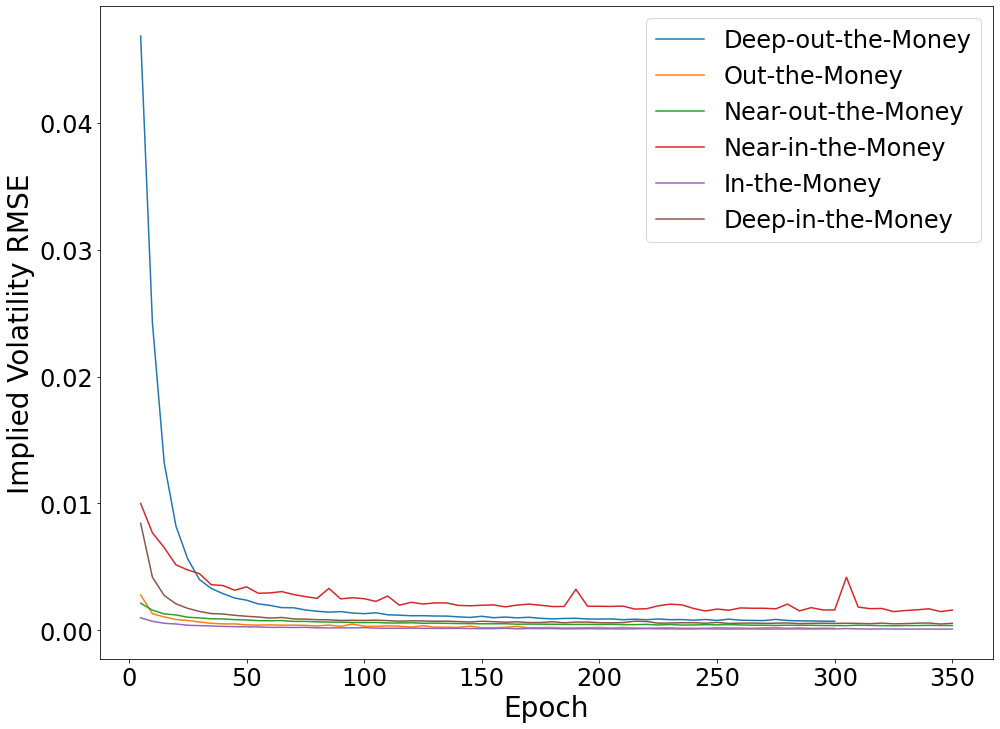

In [ ]:
plt.figure(figsize=(16, 12))
plt.plot(test_epochs[:60], test_loss[:60], label='Deep-out-the-Money')
plt.plot(test_epochs[60:120], test_loss[60:120], label='Out-the-Money')
plt.plot(test_epochs[120:190], test_loss[120:190], label='Near-out-the-Money')
plt.plot(test_epochs[190:260], test_loss[190:260], label='Near-in-the-Money')
plt.plot(test_epochs[260:330], test_loss[260:330], label='In-the-Money')
plt.plot(test_epochs[330:], test_loss[330:], label='Deep-in-the-Money')
# plt.plot(test_epochs, mapes)
plt.xlabel('Epoch')
plt.ylabel('Implied Volatility RMSE')
plt.legend()
plt.savefig('test_loss_exp3.png')
plt.show()

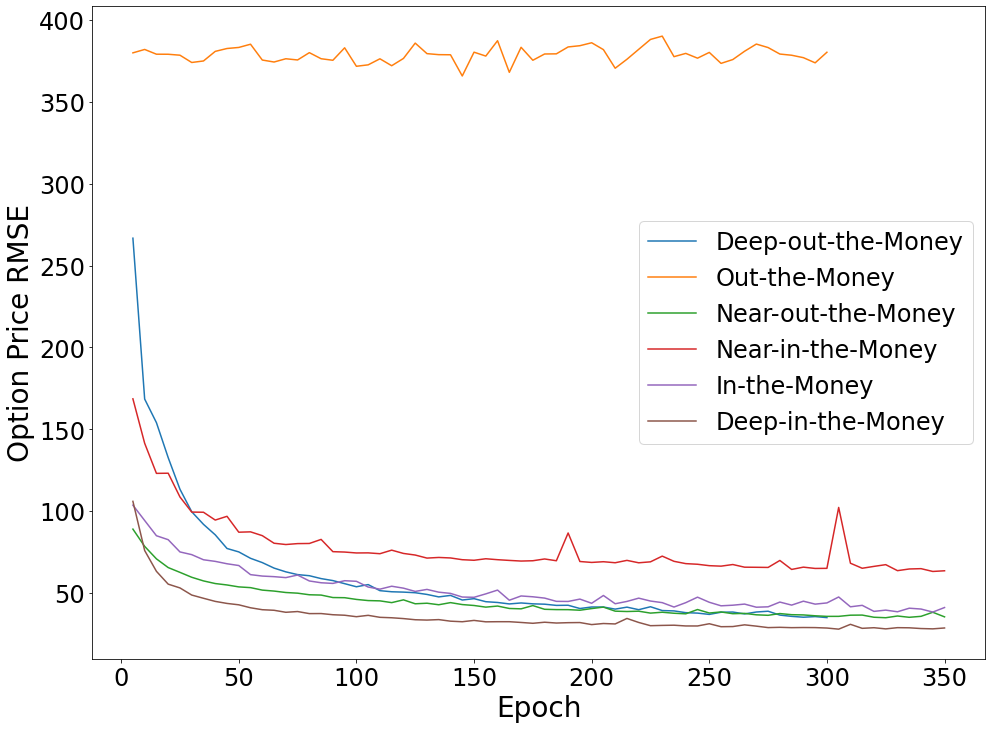

In [ ]:
plt.figure(figsize=(16, 12))
plt.plot(test_epochs[:60], rmses[:60], label='Deep-out-the-Money')
plt.plot(test_epochs[60:120], rmses[60:120], label='Out-the-Money')
plt.plot(test_epochs[120:190], rmses[120:190], label='Near-out-the-Money')
plt.plot(test_epochs[190:260], rmses[190:260], label='Near-in-the-Money')
plt.plot(test_epochs[260:330], rmses[260:330], label='In-the-Money')
plt.plot(test_epochs[330:], rmses[330:], label='Deep-in-the-Money')
plt.xlabel('Epoch')
plt.ylabel('Option Price RMSE')
plt.legend()
plt.savefig('rmse_exp3.png')
plt.show()

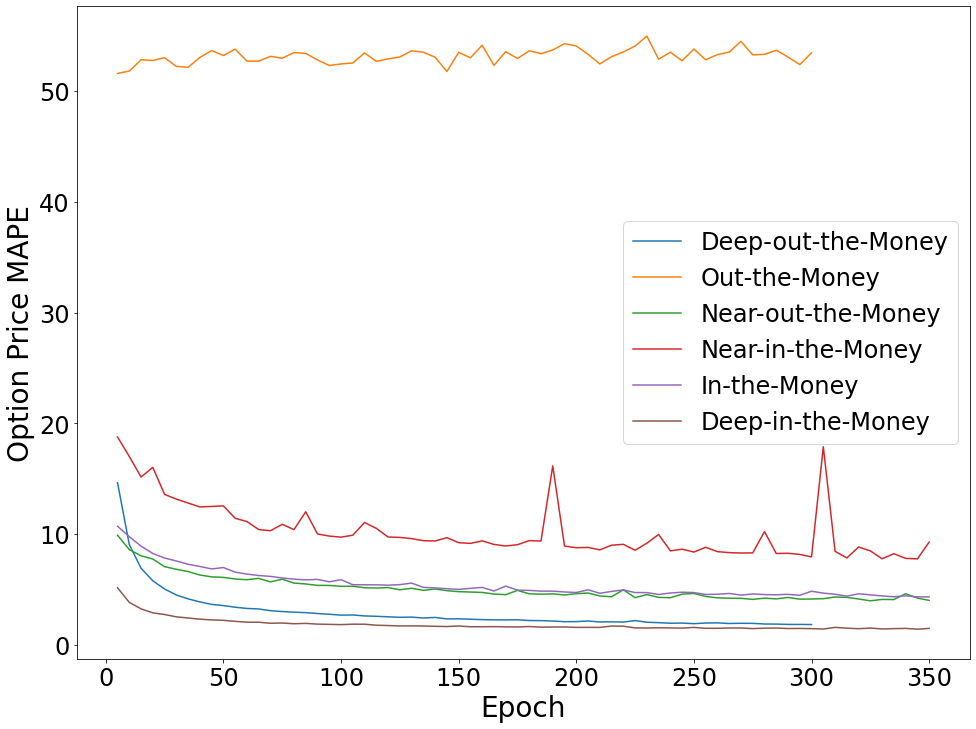

In [ ]:
plt.figure(figsize=(16, 12))
plt.plot(test_epochs[:60], mapes[:60], label='Deep-out-the-Money')
plt.plot(test_epochs[60:120], mapes[60:120], label='Out-the-Money')
plt.plot(test_epochs[120:190], mapes[120:190], label='Near-out-the-Money')
plt.plot(test_epochs[190:260], mapes[190:260], label='Near-in-the-Money')
plt.plot(test_epochs[260:330], mapes[260:330], label='In-the-Money')
plt.plot(test_epochs[330:], mapes[330:], label='Deep-in-the-Money')
plt.xlabel('Epoch')
plt.ylabel('Option Price MAPE')
plt.legend()
plt.savefig('mape_exp3.png')
plt.show()

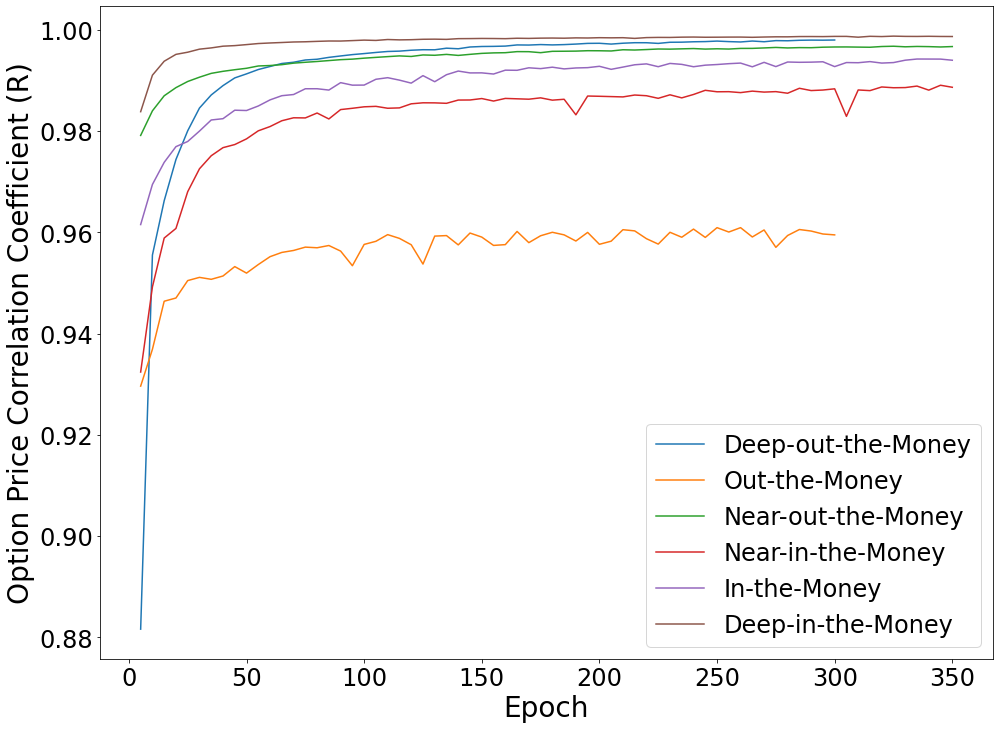

In [ ]:
plt.figure(figsize=(16, 12))
plt.plot(test_epochs[:60], ccfs[:60], label='Deep-out-the-Money')
plt.plot(test_epochs[60:120], ccfs[60:120], label='Out-the-Money')
plt.plot(test_epochs[120:190], ccfs[120:190], label='Near-out-the-Money')
plt.plot(test_epochs[190:260], ccfs[190:260], label='Near-in-the-Money')
plt.plot(test_epochs[260:330], ccfs[260:330], label='In-the-Money')
plt.plot(test_epochs[330:], ccfs[330:], label='Deep-in-the-Money')
plt.xlabel('Epoch')
plt.ylabel('Option Price Correlation Coefficient (R)')
plt.legend()
plt.savefig('ccf_exp3.png')
plt.show()

In [ ]:
print(training_loss)

[0.13561034202575684, 0.08276569843292236, 0.06508661061525345, 0.05616911128163338, 0.04922568425536156, 0.04327774792909622, 0.03794507309794426, 0.03319384157657623, 0.028939565643668175, 0.025489281862974167, 0.02236601710319519, 0.0197872593998909, 0.017746413126587868, 0.01603488251566887, 0.014304899610579014, 0.012974703684449196, 0.011829819530248642, 0.010824534110724926, 0.009874164126813412, 0.009069740772247314, 0.008662249892950058, 0.007889237254858017, 0.007285485975444317, 0.006949843373149633, 0.006393790245056152, 0.006126189138740301, 0.00581251410767436, 0.005362140946090221, 0.0051564788445830345, 0.004968200344592333, 0.004827071912586689, 0.004606335423886776, 0.004513557069003582, 0.0044549270533025265, 0.004259136039763689, 0.0040526618249714375, 0.0039012213237583637, 0.0038739603478461504, 0.003899928880855441, 0.0037555324379354715, 0.003683405229821801, 0.0034719575196504593, 0.0035767166409641504, 0.003475265810266137, 0.003372353268787265, 0.003492648946

In [ ]:
print(val_loss)

[0.1076330915093422, 0.0764135867357254, 0.06489265710115433, 0.05724208056926727, 0.050902947783470154, 0.04497294872999191, 0.040033791214227676, 0.03519357368350029, 0.031335052102804184, 0.027918774634599686, 0.024661634117364883, 0.022065578028559685, 0.019851064309477806, 0.017858047038316727, 0.015772176906466484, 0.013956831768155098, 0.012877402827143669, 0.011824936605989933, 0.010769996792078018, 0.00985713116824627, 0.008908410556614399, 0.008338609710335732, 0.007493108045309782, 0.007243409752845764, 0.007425464689731598, 0.006461610551923513, 0.005956924520432949, 0.005630700383335352, 0.005352563690394163, 0.004974063020199537, 0.004665277432650328, 0.004566385876387358, 0.004337156191468239, 0.004230785183608532, 0.003939423710107803, 0.003922534640878439, 0.0037323331926018, 0.0036004504654556513, 0.0035039258655160666, 0.0034758998081088066, 0.003188398899510503, 0.0032362081110477448, 0.0031710760667920113, 0.003439327236264944, 0.0032444943208247423, 0.003080057911

In [ ]:
print(test_loss)

[0.046814970672130585, 0.024240372702479362, 0.013219914399087429, 0.008221535012125969, 0.005635486915707588, 0.004009698051959276, 0.0033098398707807064, 0.002900002058595419, 0.002549016149714589, 0.002385650994256139, 0.00208858959376812, 0.001969805685803294, 0.0017961476696655154, 0.0017871131421998143, 0.001613925094716251, 0.001512135611847043, 0.0014409124851226807, 0.0014842444797977805, 0.0013714074157178402, 0.0013213794445618987, 0.0013894591247662902, 0.0012345579452812672, 0.0012013920350000262, 0.0011569762136787176, 0.0011616908013820648, 0.0011364611564204097, 0.0011310658883303404, 0.0010692344512790442, 0.0010253589134663343, 0.001116741681471467, 0.0010028103133663535, 0.001054915483109653, 0.0009910929948091507, 0.0010373475961387157, 0.0009528486989438534, 0.0009139878093264997, 0.0009434298845008016, 0.0009574106661602855, 0.0008993471274152398, 0.0008957593236118555, 0.0009064921177923679, 0.000845801318064332, 0.0008881560643203557, 0.0008438035729341209, 0.00

In [ ]:
print(rmses)

[266.7316359658149, 168.46778484698493, 154.05479189642236, 132.6759077013419, 113.38049962543163, 99.63279749127543, 91.9369423419525, 85.53746095461625, 77.1982596245699, 75.10670469301492, 71.19264755862258, 68.57856110307907, 65.21302232874964, 62.92841450062523, 61.240951181072454, 60.570023800582454, 58.80388776940582, 57.591028489687524, 55.7097186665509, 53.8149249054398, 55.14239158405604, 51.42980320984249, 50.76377103031994, 50.550086837678876, 50.172218057843025, 49.1333584651253, 47.622134305186805, 48.53545287258454, 45.71815992014962, 46.55506704514692, 44.6967852569364, 44.222364858869064, 43.33056475280325, 43.92308674066663, 43.38457882344255, 43.170424446315096, 42.437951603819485, 42.52225836023632, 40.53167616150284, 41.45663061175724, 41.429233008302845, 40.16170166058004, 41.374069157297214, 39.80922983773283, 41.61148575898621, 39.2842378413205, 39.07020861438898, 37.99901057511235, 37.724937354984434, 36.930726232218376, 38.26284634153934, 38.37877882453401, 37

In [ ]:
print(mapes)

[14.641739845275879, 9.069011688232422, 6.929924488067627, 5.792834281921387, 5.051881790161133, 4.516394138336182, 4.163464069366455, 3.8867034912109375, 3.665302276611328, 3.5579590797424316, 3.4098987579345703, 3.298394203186035, 3.2532708644866943, 3.0973873138427734, 3.020756721496582, 2.962432622909546, 2.9212429523468018, 2.8419599533081055, 2.7740280628204346, 2.696505546569824, 2.711583375930786, 2.6240477561950684, 2.588864803314209, 2.544987440109253, 2.5000128746032715, 2.517098903656006, 2.439715623855591, 2.4871366024017334, 2.3577911853790283, 2.3622934818267822, 2.3270742893218994, 2.289802312850952, 2.27209734916687, 2.2652885913848877, 2.2756869792938232, 2.211275339126587, 2.1993062496185303, 2.163224935531616, 2.1048049926757812, 2.1107077598571777, 2.1691231727600098, 2.0783064365386963, 2.0927350521087646, 2.069575548171997, 2.2038800716400146, 2.054978370666504, 2.016544818878174, 1.9653339385986328, 1.9795979261398315, 1.9249317646026611, 1.9850295782089233, 1.9

In [ ]:
print(ccfs)

[0.8816116462169091, 0.9555270886892372, 0.9662544051361193, 0.9744082998984301, 0.9800826243592541, 0.9845767058355793, 0.9871626439633576, 0.989006110646162, 0.990529664203308, 0.9913275010655587, 0.9921856044999084, 0.992785620014268, 0.9933781408601983, 0.9936265354523087, 0.994072154682506, 0.9942190533664745, 0.9945879098185617, 0.9948671194216213, 0.9951345706404027, 0.9953381670063505, 0.9955600473641933, 0.9957539934206262, 0.9958210493661666, 0.9959983759870823, 0.9961000723071067, 0.9960852442274323, 0.9964035573225772, 0.9962896502784218, 0.9966376222414829, 0.9967377758265514, 0.9967619038364666, 0.9968164629739505, 0.9970461471553916, 0.9970222010710823, 0.9971176635056233, 0.9970507936248273, 0.9971118347787417, 0.9972157575617059, 0.9973524270379436, 0.9973725774847736, 0.9972156664541049, 0.9973852511194713, 0.9974852413576605, 0.9974803847288622, 0.9973496093169923, 0.9975734806961075, 0.997590683708987, 0.9976695478140826, 0.9977055330596111, 0.9978070192670841, 0.99

In [ ]:
len(test_loss)

400

In [ ]:
for i in range(len(predicted_option_prices)):
  print(predicted_option_prices[i])
  print(real_option_prices[i])

[1325.2701544461288, 1432.58541546171, 850.2695867527345, 1702.1779337435728, 862.3832744899264, 1104.7595130674217, 1400.312612884285, 1364.040075066845, 485.9492761105939, 1668.3606002465967, 1072.5046395387626, 729.9413570273064, 1001.7020026001355, 1784.206986583653, 1219.0669517905262, 3053.9371006541705, 716.5194701927594, 1959.9719902319366, 1708.0904813651014, 1500.1907629059478, 1361.977604230663, 493.44245538619725, 958.2485649717182, 672.1581952633824, 1095.157897163559, 796.041667489364, 1265.8059610018408, 1470.0304021606207, 4292.102090763228, 544.6698184109518, 3192.282756421261, 1711.8402560500263, 1409.46718698707, 1473.1479214654664, 1960.9673607597242, 1267.9140397012397, 2871.8639206851676, 1289.580658792488, 1985.189242512436, 1268.4425870714385, 1327.4143627181766, 1114.874505777193, 918.8535328028183, 1447.5436781597336, 1369.8693594324031, 1058.9495135523666, 621.6127481698086, 3674.7685349324174, 1214.270828097604, 1242.7045939861418, 1066.7606575935333, 2073.8

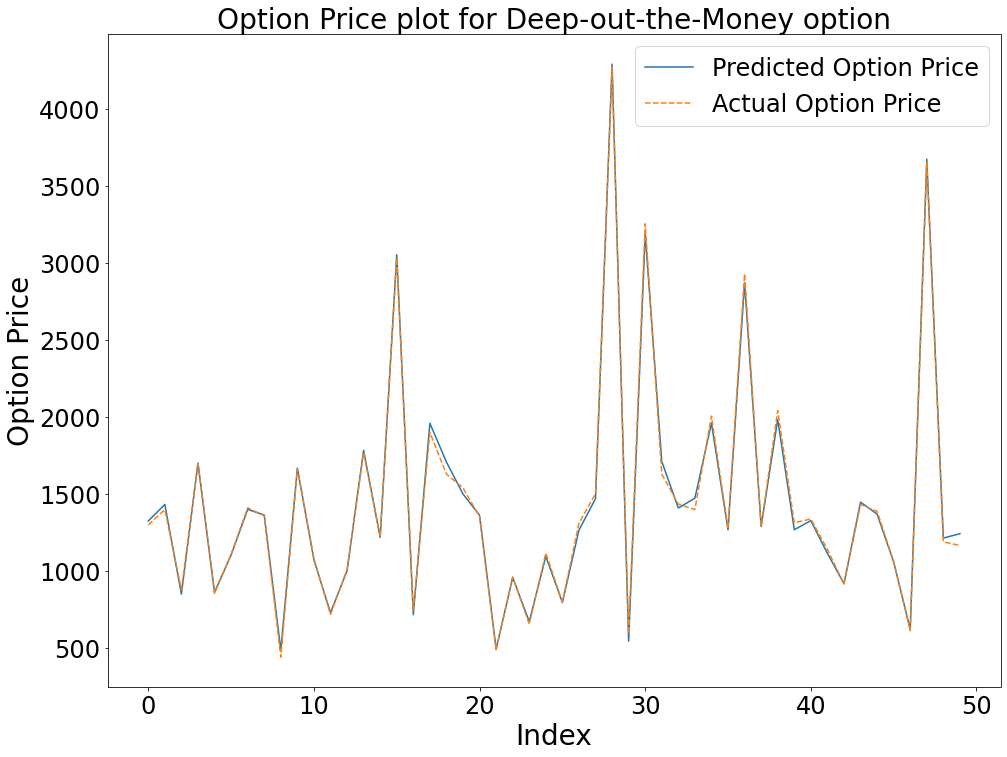

In [ ]:
plt.figure(figsize=(16, 12))
plt.plot(predicted_option_prices[0][0:50], label='Predicted Option Price')
plt.plot(real_option_prices[0][0:50],'--', label='Actual Option Price')
plt.xlabel('Index')
plt.ylabel('Option Price')
plt.title('Option Price plot for Deep-out-the-Money option')
plt.legend()
plt.savefig('price_comparision0.png')
plt.show()

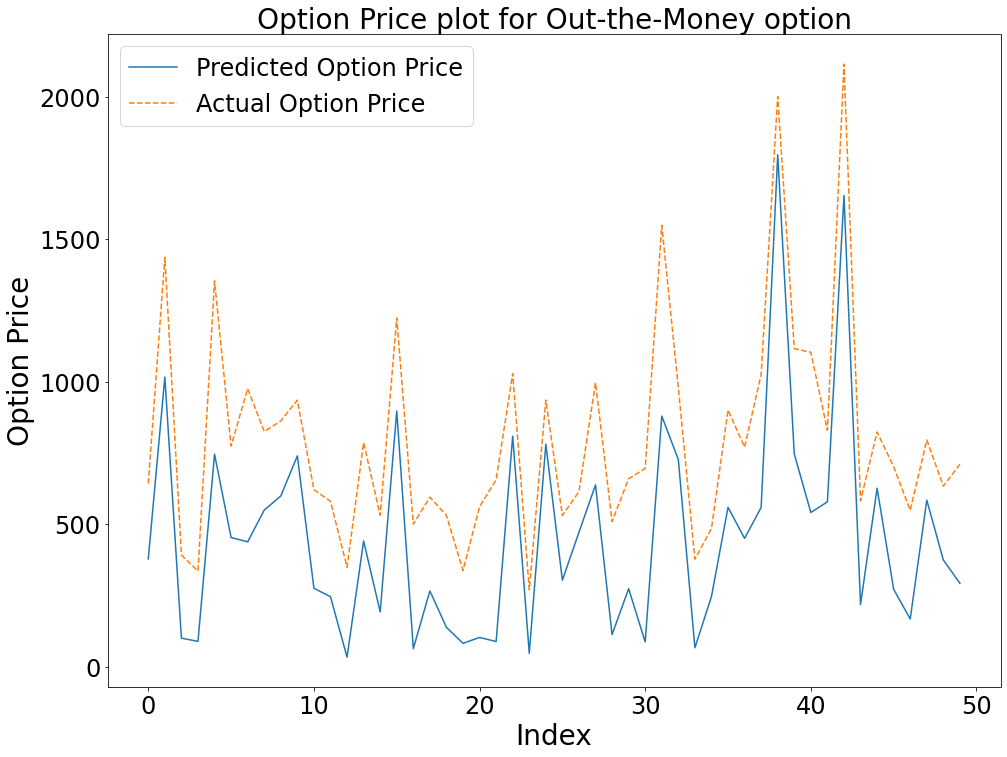

In [ ]:
plt.figure(figsize=(16, 12))
plt.plot(predicted_option_prices[1][0:50], label='Predicted Option Price')
plt.plot(real_option_prices[1][0:50],'--', label='Actual Option Price')
plt.xlabel('Index')
plt.ylabel('Option Price')
plt.title('Option Price plot for Out-the-Money option')
plt.legend()
plt.savefig('price_comparision1.png')
plt.show()

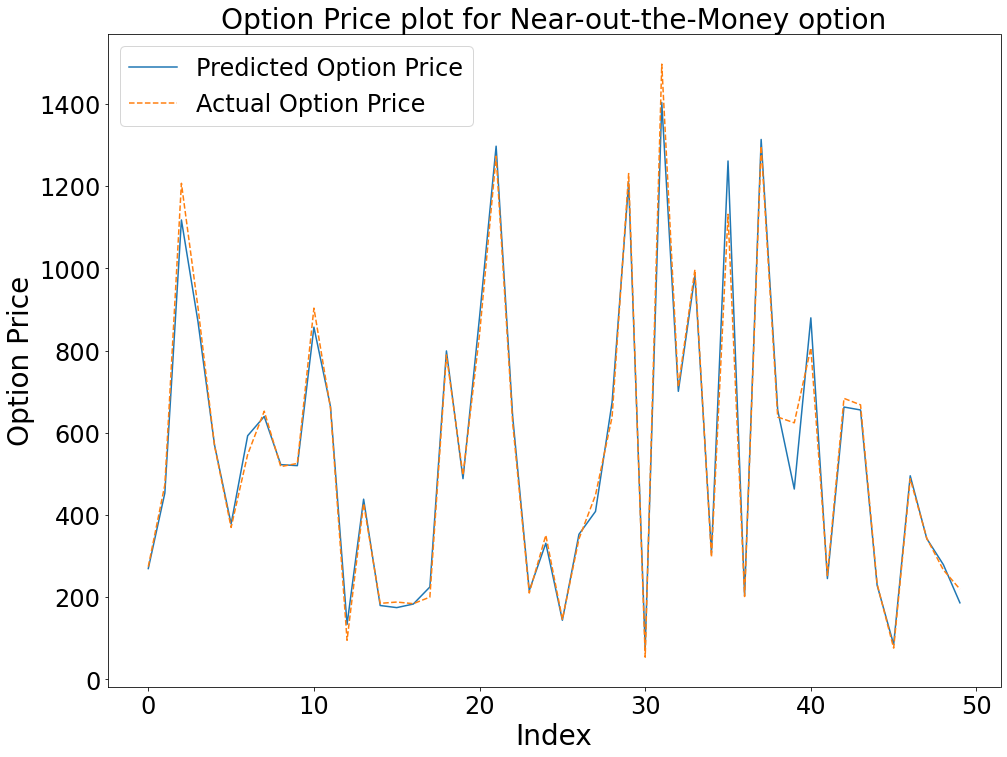

In [ ]:
plt.figure(figsize=(16, 12))
plt.plot(predicted_option_prices[2][0:50], label='Predicted Option Price')
plt.plot(real_option_prices[2][0:50],'--', label='Actual Option Price')
plt.xlabel('Index')
plt.ylabel('Option Price')
plt.title('Option Price plot for Near-out-the-Money option')
plt.legend()
plt.savefig('price_comparision2.png')
plt.show()

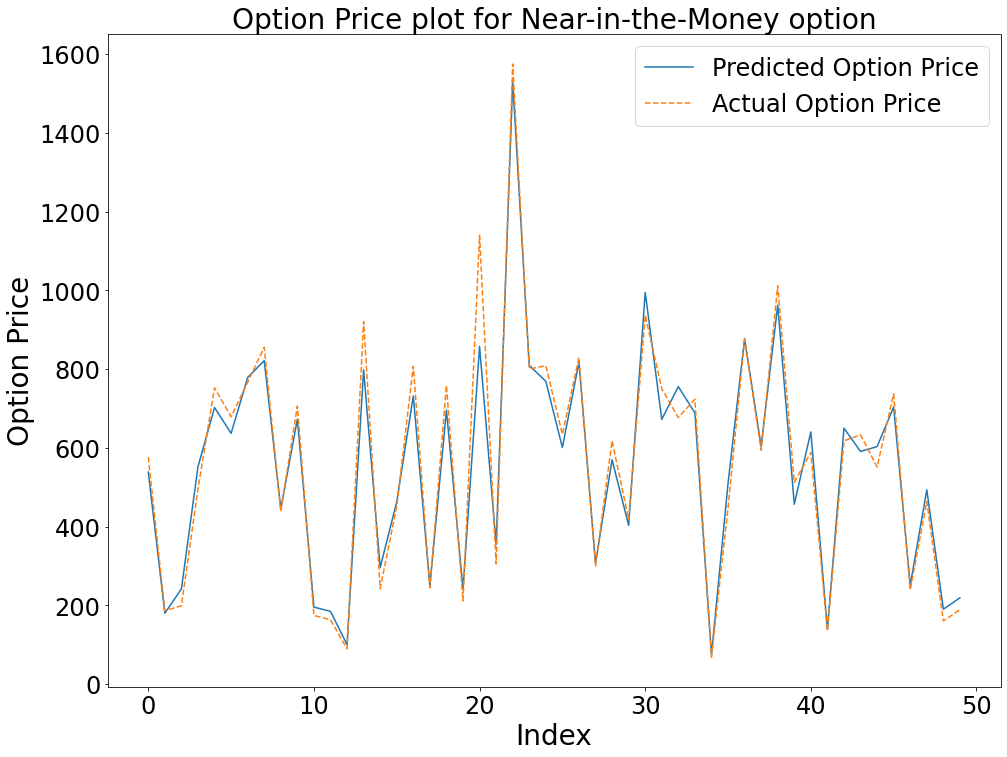

In [ ]:
plt.figure(figsize=(16, 12))
plt.plot(predicted_option_prices[3][0:50], label='Predicted Option Price')
plt.plot(real_option_prices[3][0:50],'--', label='Actual Option Price')
plt.xlabel('Index')
plt.ylabel('Option Price')
plt.title('Option Price plot for Near-in-the-Money option')
plt.legend()
plt.savefig('price_comparision3.png')
plt.show()

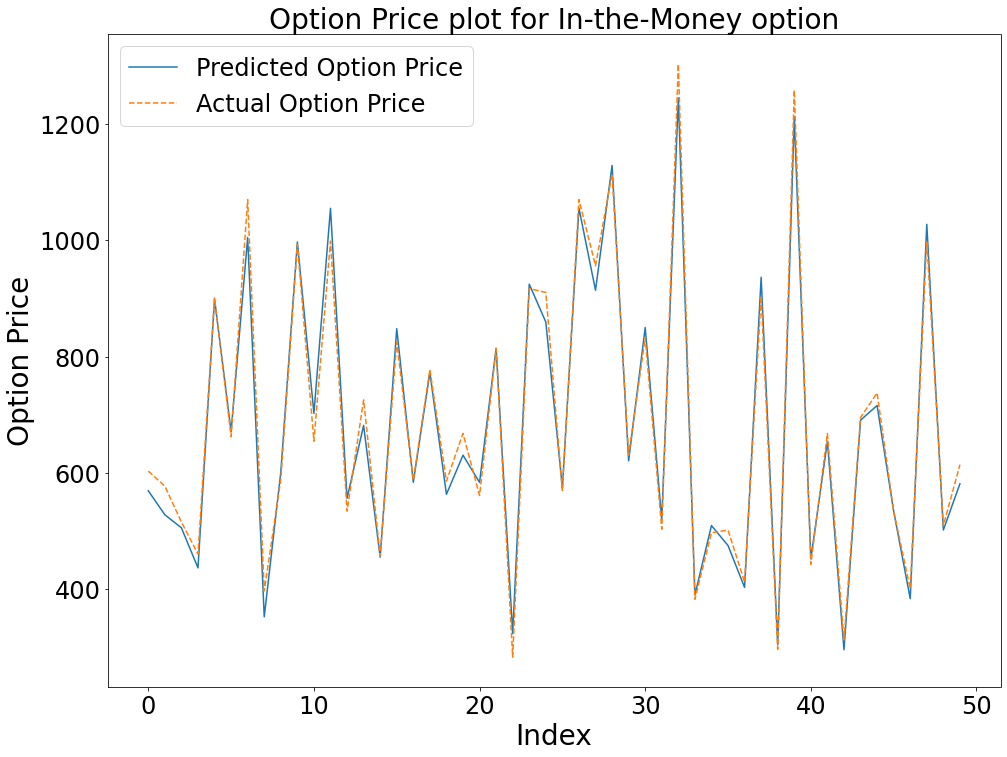

In [ ]:
plt.figure(figsize=(16, 12))
plt.plot(predicted_option_prices[4][0:50], label='Predicted Option Price')
plt.plot(real_option_prices[4][0:50],'--', label='Actual Option Price')
plt.xlabel('Index')
plt.ylabel('Option Price')
plt.title('Option Price plot for In-the-Money option')
plt.legend()
plt.savefig('price_comparision4.png')
plt.show()

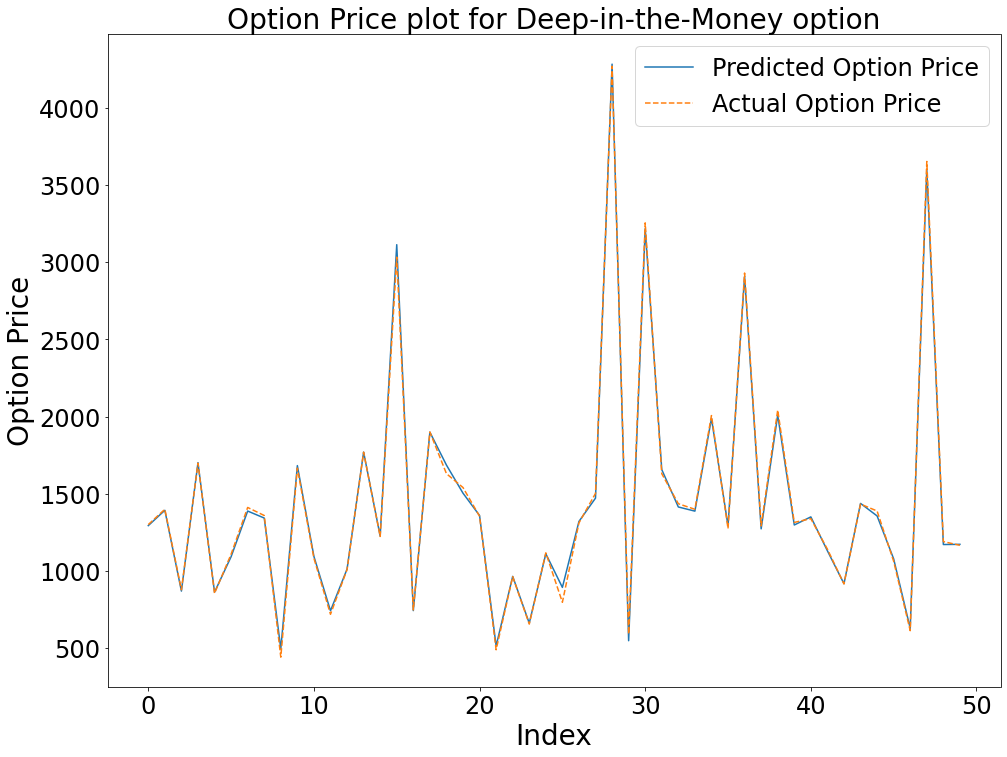

In [ ]:
plt.figure(figsize=(16, 12))
plt.plot(predicted_option_prices[5][0:50], label='Predicted Option Price')
plt.plot(real_option_prices[5][0:50],'--', label='Actual Option Price')
plt.xlabel('Index')
plt.ylabel('Option Price')
plt.title('Option Price plot for Deep-in-the-Money option')
plt.legend()
plt.savefig('price_comparision5.png')
plt.show()